"""
IBD diagnostic model complete process (version 1)
Functions: data preprocessing → 14 types of model training → hyperparameter optimization → multidimensional evaluation → report generation
Environment requirements: Python 3.8+, Google Colab
"""

# =============== Environment Configuration ===============

In [ ]:
!python -m venv ibd_env

Error: Command '['/content/ibd_env/bin/python3', '-m', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.


In [ ]:
!source ibd_env/bin/activate

/bin/bash: line 1: ibd_env/bin/activate: No such file or directory


In [ ]:
!pip install -q --force-reinstall \
    numpy==1.26.4 \
    pandas==2.2.2 \
    scikit-learn==1.3.2 \
    xgboost==1.7.5 \
    lightgbm==3.3.5 \
    catboost==1.2.6 \
    shap==0.44.0 \
    scipy==1.11.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.6/533.6 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
!pip install dask[dataframe]

In [ ]:
import numpy as np
import pandas as pd
from pandas import json_normalize
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import joblib
from scipy.stats import sem, t
from sklearn import naive_bayes, metrics, model_selection, preprocessing, ensemble, svm, neural_network, neighbors, linear_model, discriminant_analysis
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.base import clone
from sklearn.metrics import (roc_auc_score, precision_score, accuracy_score,
                            recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import shap

# =============== Parameter Configuration ===============

In [ ]:
RANDOM_STATE = 41
TEST_SIZE = 0.2
CV_FOLDS = 10
N_ITER = 10 # Total parameter combination number control
USE_GPU = False  # Force disable GPU to ensure compatibility

In [ ]:
# Configure matplotlib to display
plt.rcParams.update({
    'font.family': 'DejaVu Sans',  # Sans Serif Fonts Improve Readability
    'font.size': 12,
    'figure.figsize': (10, 6),
    'axes.titlesize': 10,         # Remove redundant headings
    'xtick.labelsize': 10,        # Scale Alignment Body Font Size
    'figure.dpi': 300,
    'savefig.bbox': 'tight'
})

# =============== Data preparation ===============

In [ ]:
# Step 2: Upload data files
print("\nStep 2: Uploading data files...")

uploaded = files.upload()


Step 2: Uploading data files...


Saving distinct_species.xlsx to distinct_species.xlsx
Saving IBD_vs_HC_species_relative_abundance.xlsx to IBD_vs_HC_species_relative_abundance.xlsx
Saving shared_species.xlsx to shared_species.xlsx


In [ ]:
def load_data():
    # Data loading (example path, need to replace with real path)
    main_df = pd.read_excel('IBD_vs_HC_species_relative_abundance.xlsx')
    # shared_species_df = pd.read_excel('shared_species.xlsx')

    # Data Cleaning
    labels = main_df.iloc[0, 1:].replace({'IBD':1, 'HC':0}).astype(int)

    # feature engineering
    # Construct a characterization matrix (rows: species, columns: samples)
    features = main_df.iloc[1:, 1:].copy()
    features.index = main_df.iloc[1:, 0].str.split('s__').str[-1]  # Simplification of species names
    features = features.apply(pd.to_numeric, errors='coerce').fillna(0)

    # Weighting of shared species characteristics (example: 1x weight)
    # shared_species = shared_species_df.iloc[1:,0].str.split('s__').str[-1].tolist()
    # features.loc[features.index.intersection(shared_species)] *= 1.0

    return features.T, labels  # Transpose to sample x feature format

In [ ]:
# Load data
print("Load data...")
X, y = load_data()
print(f"data shape：{X.shape}，Category distribution：\n{y.value_counts()}")

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

加载数据...


Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


数据形状：(1210, 216)，类别分布：
0
1    811
0    399
Name: count, dtype: int64


# =============== Model Configuration ===============

In [ ]:
def get_models_config():
    ratio = (y == 0).sum() / (y == 1).sum()  # Category Balance Ratio

    return {
        # integrated tree model
        'XGBoost': {
            'model': XGBClassifier(
                n_jobs=-1,
                scale_pos_weight=ratio,
                eval_metric='logloss',
                #use_label_encoder=False,
                tree_method='hist'  # Using the CPU Histogram Method
            ),
            'params': {
                'n_estimators': [200, 300, 400],
                'max_depth': [8, 9, 10],
                'learning_rate': [0.04, 0.05, 0.06]
            }
        },
        'LightGBM': {
            'model': LGBMClassifier(
                n_jobs=-1,
                scale_pos_weight=ratio,
                device='cpu'
            ),
            'params': {
                'num_leaves': [45, 50, 55],
                'max_depth': [6, 7, 8],
                'learning_rate': [0.1, 0.2, 0.3],
                'min_child_samples': [9, 10, 11]
            }
        },
        'CatBoost': {
            'model': CatBoostClassifier(
                verbose=0,
                thread_count=-1,
                auto_class_weights='Balanced'
            ),
            'params': {
                'iterations': [580, 600, 650],
                'depth': [6, 7, 8],
                'learning_rate': [0.088, 0.09, 0.092]
            }
        },
        'RandomForest': {
            'model': ensemble.RandomForestClassifier(
                n_jobs=-1,
                class_weight='balanced'
            ),
            'params': {
                'n_estimators': [400, 600],
                'max_depth': [15, 20],
                'min_samples_split': [3, 4, 5]
            }
        },

        # linear model
        'Logistic': {
            'model': linear_model.LogisticRegression(
                class_weight='balanced',
                solver='saga',
                n_jobs=-1,
                max_iter=9000,
                tol=1e-9
            ),
            'params': {
                'C': np.logspace(-3, -1, 1, 1.5, 2),
                'penalty': ['l1', 'l2']
            }
        },

        # Other models
        'SVM': {
            'model': svm.SVC(
                probability=True,
                class_weight='balanced',
                kernel='rbf'
            ),
            'params': {
                'C': [5, 6, 7, 8, 9],
                'gamma': ['scale', 'auto']
            }
        },
        'KNN': {
            'model': neighbors.KNeighborsClassifier(
                n_jobs=-1
            ),
            'params': {
                'n_neighbors': [7, 8, 9, 10, 11],
                'weights': ['uniform', 'distance']
            }
        },
        'HistGBM': {
            'model': ensemble.HistGradientBoostingClassifier(),
            'params': {
                'max_iter': [300, 400, 500],
                'learning_rate': [0.07, 0.1, 0.2],
                'max_depth': [6, 7, 8]
            }
        },
        # Gradient lifting variant
        'AdaBoost': {
            'model': ensemble.AdaBoostClassifier(),
            'params': {
                'n_estimators': [800, 900, 1000],
                'learning_rate': [0.05, 0.1, 0.2],
                'algorithm': ['SAMME', 'SAMME.R']
            }
        },

        # neural network
        'MLP': {
            'model': neural_network.MLPClassifier(
                early_stopping=True,
                batch_size=32,
                max_iter=500
            ),
            'params': {
                'hidden_layer_sizes': [(64,64), (128,), (128,128)],
                'alpha': [1e-7, 1e-6, 1e-5, 0.0001],
                'learning_rate_init': [0.005, 0.01, 0.02]
            }
        },

        # probabilistic model
        'GaussianNB': {
            'model': naive_bayes.GaussianNB(),
            'params': {
                'var_smoothing': [1e-7, 1e-6, 1e-5]
            }
        },

        # incremental learning
        'SGD': {
            'model': linear_model.SGDClassifier(
                loss='log_loss',  # Enabling probabilistic forecasting
                class_weight='balanced',
                early_stopping=True
            ),
            'params': {
                'alpha': [1, 3, 5],
                'penalty': ['l1', 'l2', 'elasticnet'],
                'l1_ratio': [0.7, 0.8, 0.9, 1]
            }
        },

        # discriminant analysis
        'LDA': {
            'model': discriminant_analysis.LinearDiscriminantAnalysis(solver='lsqr'),
            'params': {
                'shrinkage': ['auto', 0.3, 0.55], # Legal parameters adapted to the new solver
                'tol': [1e-10, 1e-9, 1e-8]
            }
        },

        # Extreme Random Trees
        'ExtraTrees': {
            'model': ensemble.ExtraTreesClassifier(
                class_weight='balanced',
                n_jobs=-1
            ),
            'params': {
                'n_estimators': [50, 90, 100],
                'max_depth': [11, 12, 13, 14],
                'min_samples_split': [2, 3]
            }
        }
    }

# =============== model training ===============

In [ ]:
def train_models():
    results = {}
    plt.figure(figsize=(12, 8))
    models_config = get_models_config()

    def bootstrap_auc(y_true, y_proba, n_bootstrap=1000):
        auc_values = []
        for _ in range(n_bootstrap):
            indices = resample(np.arange(len(y_true)))
            auc = metrics.roc_auc_score(y_true.iloc[indices], y_proba[indices])
            auc_values.append(auc)
        return np.percentile(auc_values, [2.5, 97.5])

    for name, config in models_config.items():
        try:
            print(f"\n=== Training {name} [{time.strftime('%H:%M:%S')}] ===")
            start_time = time.time()

            # Hyperparametric search
            search = model_selection.RandomizedSearchCV(
                estimator=config['model'],
                param_distributions=config['params'],
                n_iter=N_ITER,
                cv=model_selection.StratifiedKFold(CV_FOLDS),
                scoring='roc_auc',
                n_jobs=-1,
                error_score='raise'
            )
            search.fit(X_train, y_train)

            # Projected results
            y_pred = search.predict(X_test)
            y_prob = search.predict_proba(X_test)[:, 1]

            # Calculation of indicators
            auc_ci = bootstrap_auc(y_test, y_prob)
            report = metrics.classification_report(y_test, y_pred, output_dict=True)

            # Save results
            results[name] = {
                'model': search.best_estimator_,
                'best_params': search.best_params_,
                'auc': metrics.roc_auc_score(y_test, y_prob),
                'auc_ci': auc_ci,
                'precision': metrics.precision_score(y_test, y_pred),
                'recall': metrics.recall_score(y_test, y_pred),
                'accuracy': report['accuracy'],
                'f1': report['1']['f1-score'],
                'time': time.time() - start_time
            }

            # Plotting the ROC curve
            fpr, tpr, _ = metrics.roc_curve(y_test, y_prob)
            plt.plot(fpr, tpr, lw=2.5, marker='o', ms=5,
              label=f"{name} (AUC={results[name]['auc']:.3f}, 95% CI: {results[name]['auc_ci'][0]:.3f}-{results[name]['auc_ci'][1]:.3f})")

        except Exception as e:
            print(f"train {name} fail (e.g. experiments): {str(e)}")
            continue

    # Drawing settings optimization
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
    plt.xlabel('False Positive Rate', fontsize=12, labelpad=8)
    plt.ylabel('True Positive Rate', fontsize=12, labelpad=8)
    plt.title('ROC Curve (IBD_vs_HC)', fontsize=14, pad=12)
    plt.legend(loc='lower right', frameon=True,
              fontsize=9, borderpad=0.8)

    # Setting the save parameters
    plt.savefig('/content/drive/MyDrive/code/IBD/2stage/stage1/roc_comparison.png',
              dpi=300,
              bbox_inches='tight',
              pad_inches=0.2)

    return results



# =============== Executive training ===============


=== Training XGBoost [05:44:28] ===

=== Training LightGBM [05:46:16] ===

=== Training CatBoost [05:46:35] ===

=== Training RandomForest [06:16:55] ===

=== Training Logistic [06:17:49] ===


The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.



=== Training SVM [06:19:28] ===

=== Training KNN [06:19:41] ===


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7fe069dd0720>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error



=== Training HistGBM [06:19:43] ===

=== Training AdaBoost [06:20:55] ===

=== Training MLP [06:24:50] ===

=== Training GaussianNB [06:25:04] ===


The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.



=== Training SGD [06:25:06] ===

=== Training LDA [06:25:08] ===


The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.



=== Training ExtraTrees [06:25:11] ===


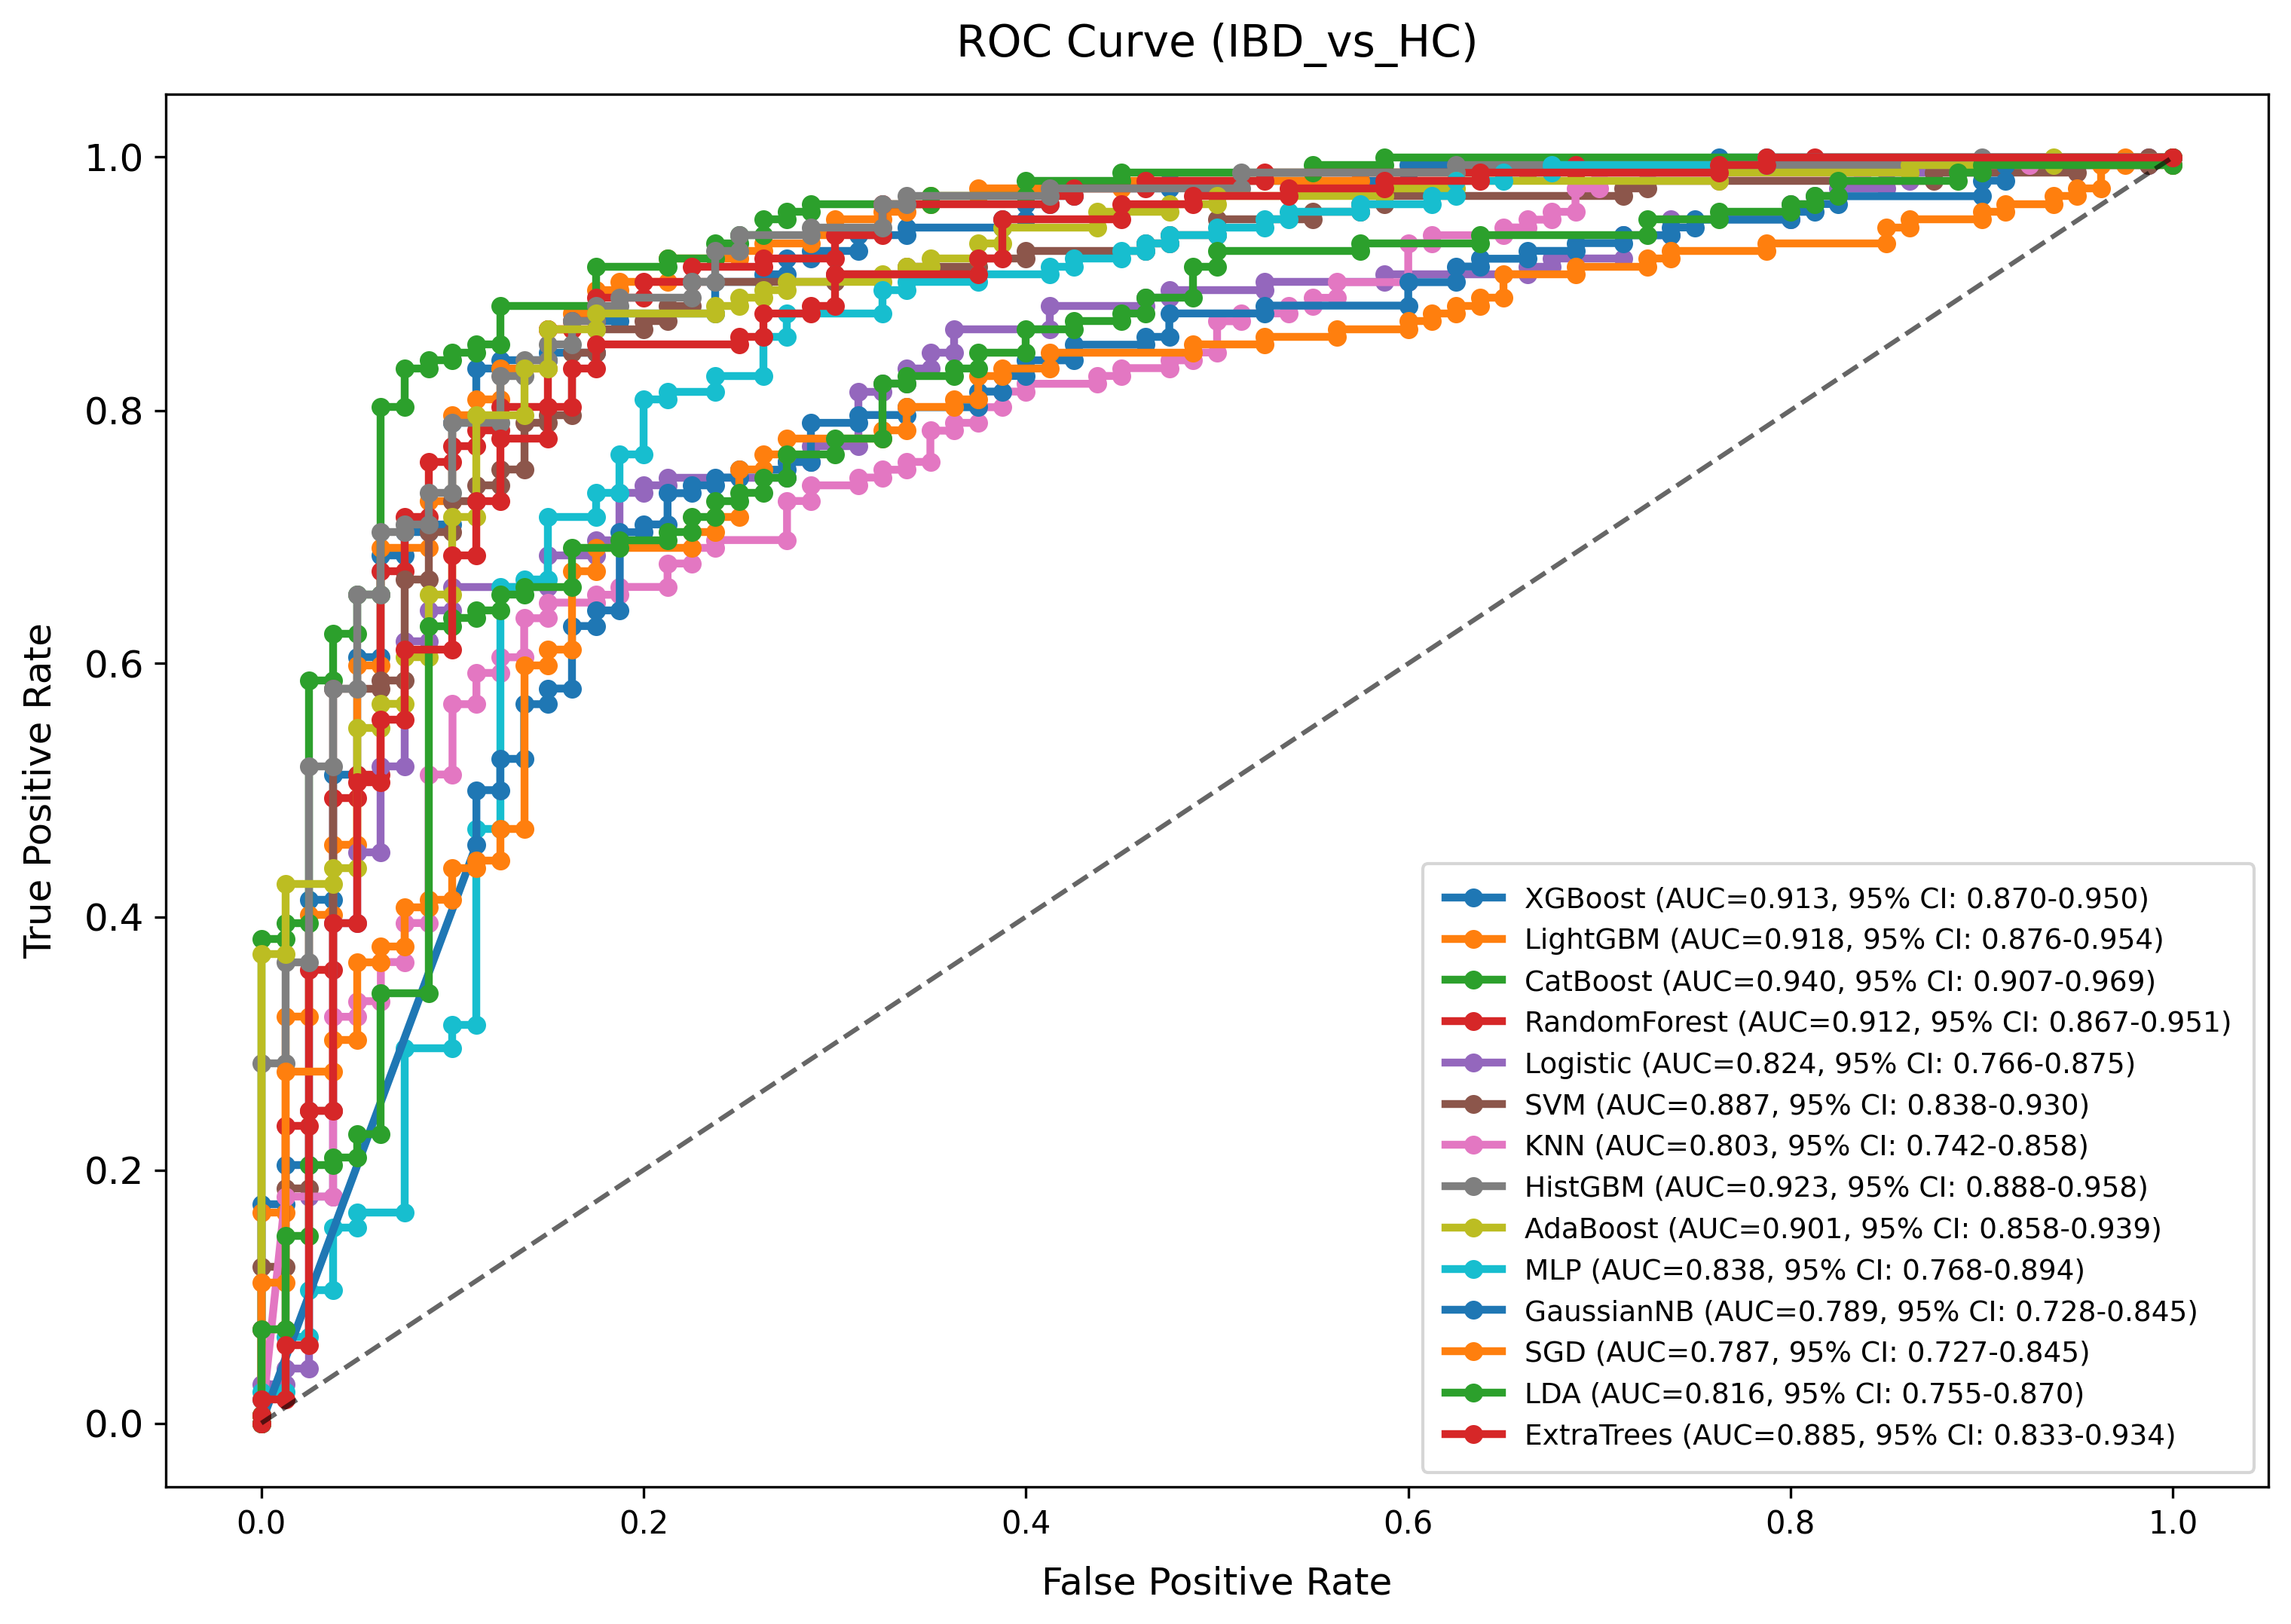

In [ ]:
results = train_models()

# =============== Analysis of results ===============

In [ ]:
# Updated parameter table generation logic
params_list = []
for model_name, res in results.items():
    try:
        # Handling nested dictionary parameter structures
        flat_params = pd.json_normalize(res['best_params'], sep='__').to_dict(orient='records')[0]
        params_list.append({
            'Model': model_name,
            'Best_Parameters': '\n'.join([f"{k}: {v}" for k, v in flat_params.items()])
        })
    except:
        params_list.append({
            'Model': model_name,
            'Best_Parameters': str(res['best_params'])
        })

params_df = pd.DataFrame(params_list)
params_df.sort_values('Model', inplace=True)

# Optimized display format
from IPython.display import display, HTML
display(HTML(params_df.style
            .set_properties(**{'white-space': 'pre-wrap'})
            .set_table_styles([{
                'selector': 'th',
                'props': [('text-align', 'left'), ('max-width', '300px')]
            }])
            .to_html()))

In [ ]:
# Generate a performance comparison table
final_metrics = pd.DataFrame(
    [(name,
      f"{res['auc']:.3f} ({res['auc_ci'][0]:.3f}-{res['auc_ci'][1]:.3f})",
      res['accuracy'],
      res['precision'],  # Use of independently stored values
      res['recall'],
      res['f1'],
      res['time'])
     for name, res in results.items()],
    columns=['Model', 'AUC (95% CI)', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Time']
).sort_values('AUC (95% CI)', ascending=False)

In [ ]:
final_metrics

Model         AUC (95% CI)  Accuracy  Precision    Recall  \
2       CatBoost  0.940 (0.907-0.969)  0.876033   0.888235  0.932099   
7        HistGBM  0.923 (0.888-0.958)  0.867769   0.882353  0.925926   
1       LightGBM  0.918 (0.876-0.954)  0.867769   0.886905  0.919753   
0        XGBoost  0.913 (0.870-0.950)  0.847107   0.869822  0.907407   
3   RandomForest  0.912 (0.867-0.951)  0.867769   0.857143  0.962963   
8       AdaBoost  0.901 (0.858-0.939)  0.826446   0.837079  0.919753   
5            SVM  0.887 (0.838-0.930)  0.847107   0.893082  0.876543   
13    ExtraTrees  0.885 (0.833-0.934)  0.826446   0.844828  0.907407   
9            MLP  0.838 (0.768-0.894)  0.818182   0.839080  0.901235   
4       Logistic  0.824 (0.766-0.875)  0.743802   0.852113  0.746914   
12           LDA  0.816 (0.755-0.870)  0.764463   0.786885  0.888889   
6            KNN  0.803 (0.742-0.858)  0.723140   0.827586  0.740741   
10    GaussianNB  0.789 (0.728-0.845)  0.632231   0.892473  0.512346   
11           SGD  0.787 (0.727-0.845)  0.673554   0.895238  0.580247   

    F1-Score         Time  
2   0.909639  1820.765431  
7   0.903614    71.563993  
1   0.903030    18.530919  
0   0.888218   107.980015  
3   0.906977    53.292112  
8   0.876471   235.261850  
5   0.884735    12.372409  
13  0.875000     6.715128  
9   0.869048    13.821877  
4   0.796053    99.484734  
12  0.834783     2.563880  
6   0.781759     2.471779  
10  0.650980     2.071044  
11  0.704120     2.461967

In [ ]:
# Extracting the best model
best_model_name = final_metrics.iloc[0]['Model']
best_model = results[best_model_name]['model']

In [ ]:
# Results Showcase
print("\n=== Model Performance Comparison ===")
print(final_metrics.round(3).to_markdown())
print(f"\nbest model：{best_model_name}")


=== 模型性能对比 ===
|    | Model        | AUC (95% CI)        |   Accuracy |   Precision |   Recall |   F1-Score |     Time |
|---:|:-------------|:--------------------|-----------:|------------:|---------:|-----------:|---------:|
|  2 | CatBoost     | 0.940 (0.906-0.968) |      0.876 |       0.888 |    0.932 |      0.91  | 1792.44  |
|  1 | LightGBM     | 0.921 (0.882-0.956) |      0.868 |       0.878 |    0.932 |      0.904 |   20.439 |
|  7 | HistGBM      | 0.921 (0.882-0.953) |      0.86  |       0.876 |    0.92  |      0.898 |   82.862 |
|  0 | XGBoost      | 0.913 (0.873-0.950) |      0.847 |       0.87  |    0.907 |      0.888 |  108.489 |
|  3 | RandomForest | 0.911 (0.870-0.951) |      0.855 |       0.851 |    0.951 |      0.898 |   55.227 |
|  8 | AdaBoost     | 0.901 (0.857-0.939) |      0.826 |       0.837 |    0.92  |      0.876 |  233.981 |
|  5 | SVM          | 0.887 (0.841-0.930) |      0.847 |       0.893 |    0.877 |      0.885 |   12.924 |
| 13 | ExtraTrees   | 0.881 (0

In [ ]:
# Saving models and metadata during training
joblib.dump({
    'model': best_model,
    'feature_names': X_train.columns.tolist(),
    'feature_stats': X_train.agg(['min', 'max']).to_dict()
}, '/content/drive/MyDrive/code/IBD/2stage/stage1/IBD_vs_HC_best_model_with_meta.pkl')


['/content/drive/MyDrive/code/IBD/2stage/stage1/IBD_vs_HC_best_model_with_meta.pkl']

In [ ]:
# Preservation of optimal models
joblib.dump(best_model, '/content/drive/MyDrive/code/IBD/2stage/stage1/IBD_vs_HC_best_model.pkl')

['/content/drive/MyDrive/code/IBD/2stage/stage1/IBD_vs_HC_best_model.pkl']

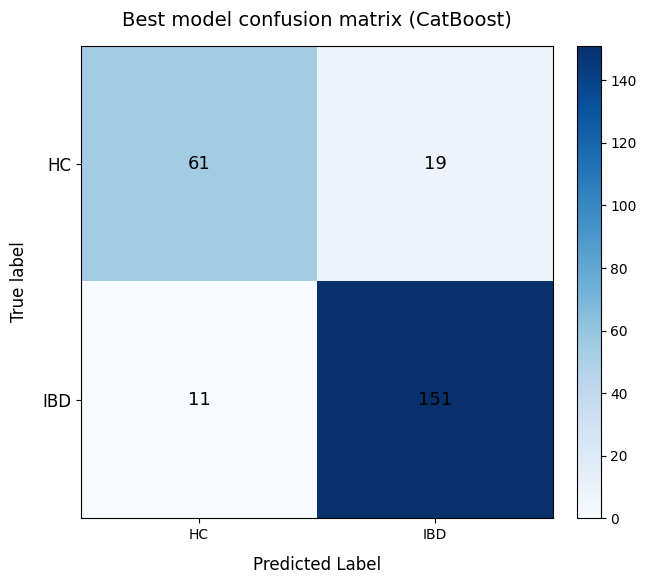

In [ ]:
# === Add obfuscated matrix code ===
# Creating a Submap System
fig, ax = plt.subplots(figsize=(7,6), dpi=100)

# Calculate the best model predictions
best_model = results[best_model_name]['model']
y_pred_all = best_model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred_all)

# Normalized Confusion Matrix Presentation (to maintain consistency with SHAP chart aesthetics)
conf_disp = ConfusionMatrixDisplay(
    conf_mat,
    display_labels=['HC', 'IBD']
)
conf_disp.plot(
    cmap='Blues',
    colorbar=False,
    values_format='d',
    ax=ax,
    text_kw={
        'fontsize': 13,
        'color': 'black'
    }
)

# Format Optimization Settings
ax.set_xlabel('Predicted Label',
             fontsize=12,
             fontfamily='DejaVu Sans',
             labelpad=10)
ax.set_ylabel('True label',
             fontsize=12,
             fontfamily='DejaVu Sans',
             labelpad=10)
ax.set_title(f'Best model confusion matrix ({best_model_name})',
           fontsize=14,
           pad=15,
           fontfamily='DejaVu Sans')

# Add a color bar to enhance contrast
norm = plt.Normalize(vmin=0, vmax=conf_mat.max())
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Blues'),
                  ax=ax,
                  fraction=0.046,
                  pad=0.04)
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/code/IBD/2stage/stage1/best_model_confusion_matrix.png',
          bbox_inches='tight',
          dpi=300)
plt.show()


Performing SHAP analysis for model interpretability...

Generating custom-colored SHAP bar plot...

Generating SHAP beeswarm plot with consistent colors...


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


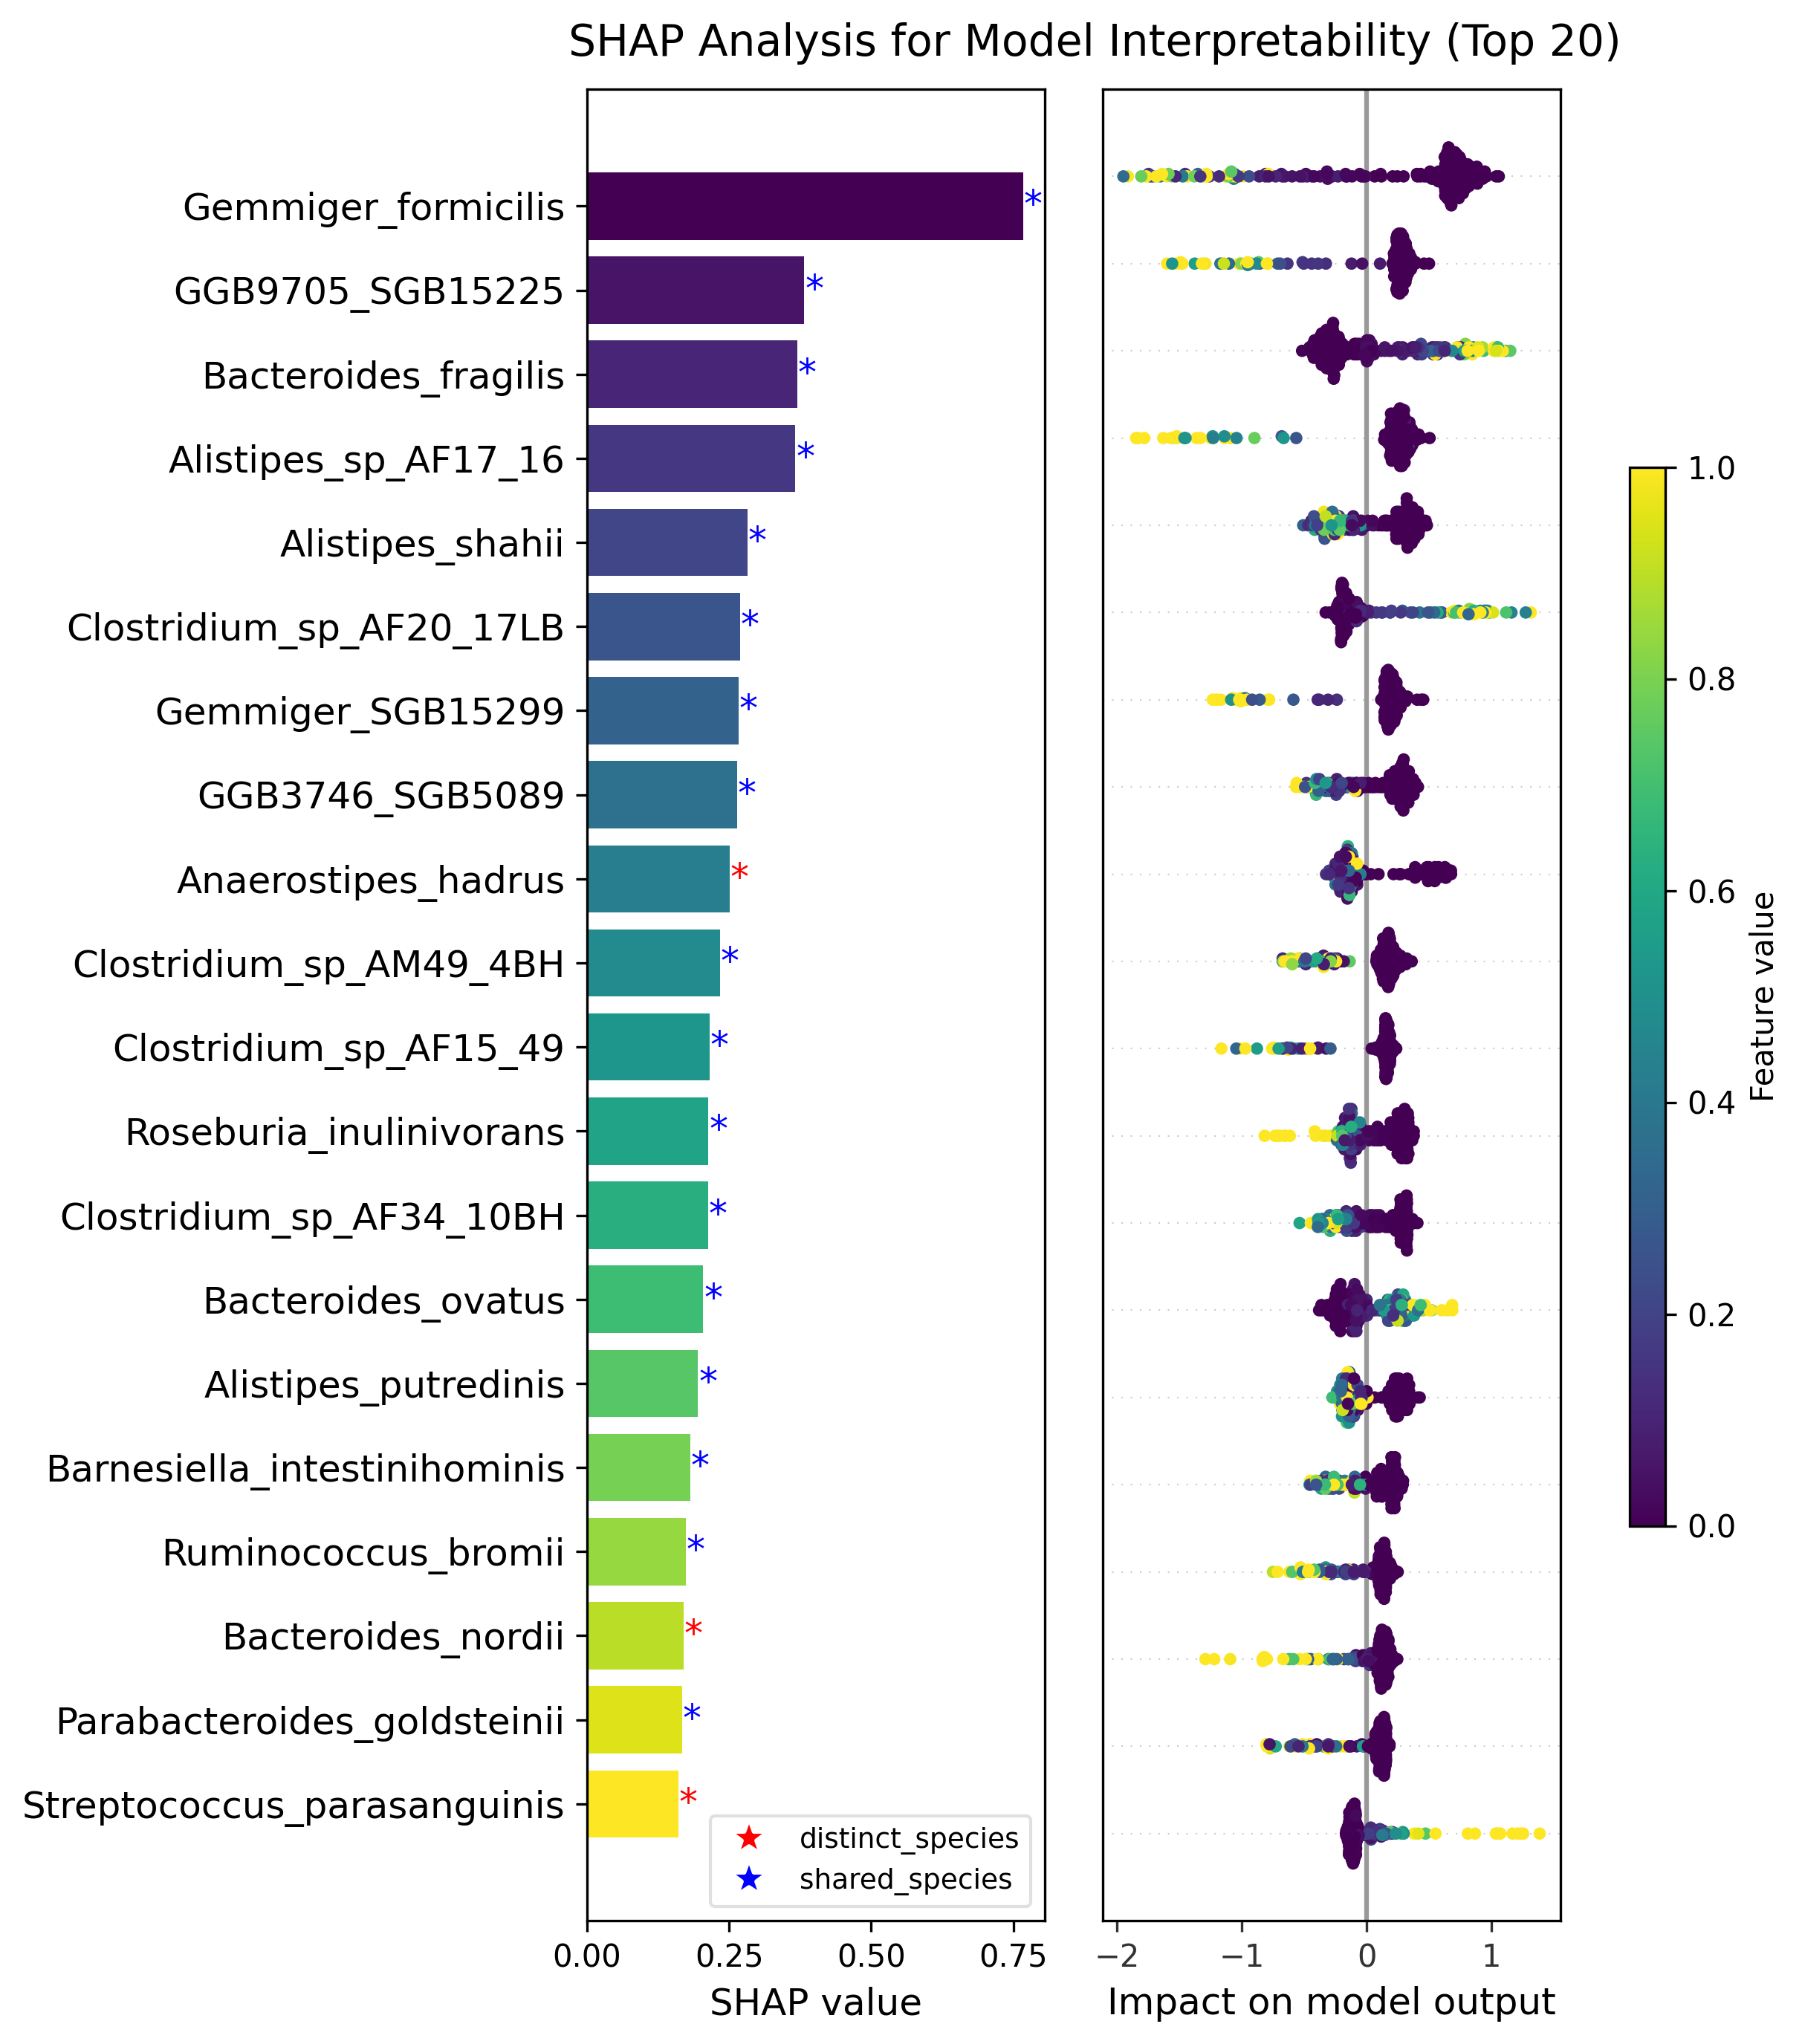

In [ ]:
# Reading a list of specific bacteria from a file
distinct_species_df = pd.read_excel('distinct_species.xlsx')
# Converting a list of specific bacteria to a list
distinct_species_list = distinct_species_df.iloc[:, 0].tolist()
# Species name after extraction of s__
distinct_species_list = distinct_species_df.iloc[:, 0].apply(lambda x: x.split('s__')[-1]).tolist()

# Read the list of commensal bacteria from the file
shared_species_df = pd.read_excel('shared_species.xlsx')
# Converting a list of commensal bacteria to a list
shared_species_list = shared_species_df.iloc[:, 0].tolist()
# Species name after extraction of s__
shared_species_list = shared_species_df.iloc[:, 0].apply(lambda x: x.split('s__')[-1]).tolist()


# Set font for all plots
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 10  # Global font size for readability
plt.rcParams['axes.titlesize'] = 10  # Title font size
plt.rcParams['axes.labelsize'] = 10  # Axis label font size
plt.rcParams['xtick.labelsize'] = 10  # X-tick label size
plt.rcParams['ytick.labelsize'] = 10  # Y-tick label size

# SHAP Analysis for model interpretability
print("\nPerforming SHAP analysis for model interpretability...")
explainer = shap.TreeExplainer(best_model)

# Generate SHAP values using explainer on X_test
shap_values_explanation = explainer(X_test)
shap_values = shap_values_explanation

# Create figure and set size to align both plots
fig, axes = plt.subplots(1, 2, figsize=(12, 8), dpi=300)
fig.subplots_adjust(wspace=0.6)  # Slightly increase space between the two plots

# 1. Custom-colored SHAP bar plot
print("\nGenerating custom-colored SHAP bar plot...")
mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)
feature_names = X_test.columns

# Store feature importance in DataFrame and sort by importance
importance_df = pd.DataFrame({'feature': feature_names, 'importance': mean_abs_shap_values})
importance_df = importance_df.sort_values(by='importance', ascending=False).head(20)

# Custom colors
colors = plt.cm.viridis(np.linspace(0, 1, len(importance_df)))

# Plot custom bar plot
axes[0].barh(importance_df['feature'], importance_df['importance'], color=colors)

legend_elements = [
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='red', markersize=12, label='distinct_species'),
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='blue', markersize=12, label='shared_species')
]

axes[0].legend(handles=legend_elements,
              loc='lower right',
              frameon=True,
              framealpha=0.9,
              edgecolor='#DDDDDD',
              title='',
              title_fontsize=10,
              fontsize=9)

axes[0].invert_yaxis()

# Add strain labeling
for i, feature in enumerate(importance_df['feature']):
    if feature in distinct_species_list:
      # Add a red star for distinct species
        axes[0].text(importance_df['importance'].iloc[i]+0.001, i, '*',
                color='red', fontsize=12, va='center')
    elif feature in shared_species_list:
      # Add a blue star for shared species
        axes[0].text(importance_df['importance'].iloc[i]+0.001, i, '*',
                color='blue', fontsize=12, va='center')

# Hide x-axis label and title by setting them as empty strings
axes[0].set_xlabel("SHAP value", fontsize=12)  # Hide x-axis label for the bar plot
axes[0].set_title("")   # Hide title for the bar plot
axes[0].tick_params(axis='y', labelsize=12)  # Increase font size for feature names

# Set consistent x-axis tick parameters for the bar plot
axes[0].tick_params(axis='x', labelsize=10)  # Ensure the x-axis tick size is consistent

# 2. SHAP beeswarm plot with consistent colors
print("\nGenerating SHAP beeswarm plot with consistent colors...")
plt.sca(axes[1])
shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=20, show=False, color_bar=False, cmap="viridis")
axes[1].tick_params(labelleft=False)
axes[1].tick_params(left=False)
axes[1].set_title("")   # Hide title for beeswarm plot
axes[1].set_xlabel("Impact on model output", fontsize=12)  # Hide x-axis label for beeswarm plot
axes[1].spines[['left', 'right', 'top']].set_visible(True)

# Set consistent x-axis tick parameters for the beeswarm plot
axes[1].tick_params(axis='x', labelsize=10)  # Ensure the x-axis tick size is consistent

# Add a color bar next to the beeswarm plot with adjusted size
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])  # Adjusted color bar position and size
sm = plt.cm.ScalarMappable(cmap="viridis")
sm.set_array([])
plt.colorbar(sm, cax=cbar_ax, label="Feature value", orientation='vertical')

# Adjust layout and save image with high resolution
# Add before plt.tight_layout()
fig.suptitle('SHAP Analysis for Model Interpretability (Top 20)',
            x=0.62,  # Precise horizontal positioning
            y=0.96,  # Precise vertical positioning
            fontsize=14,
            fontweight='normal')
# Adjusting the layout to reserve header space
plt.tight_layout(rect=[0, 0, 0.9, 0.98])  # Reserve top 5% space
plt.savefig("/content/drive/MyDrive/code/IBD/2stage/stage1/SHAP_IBD_vs_HC.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

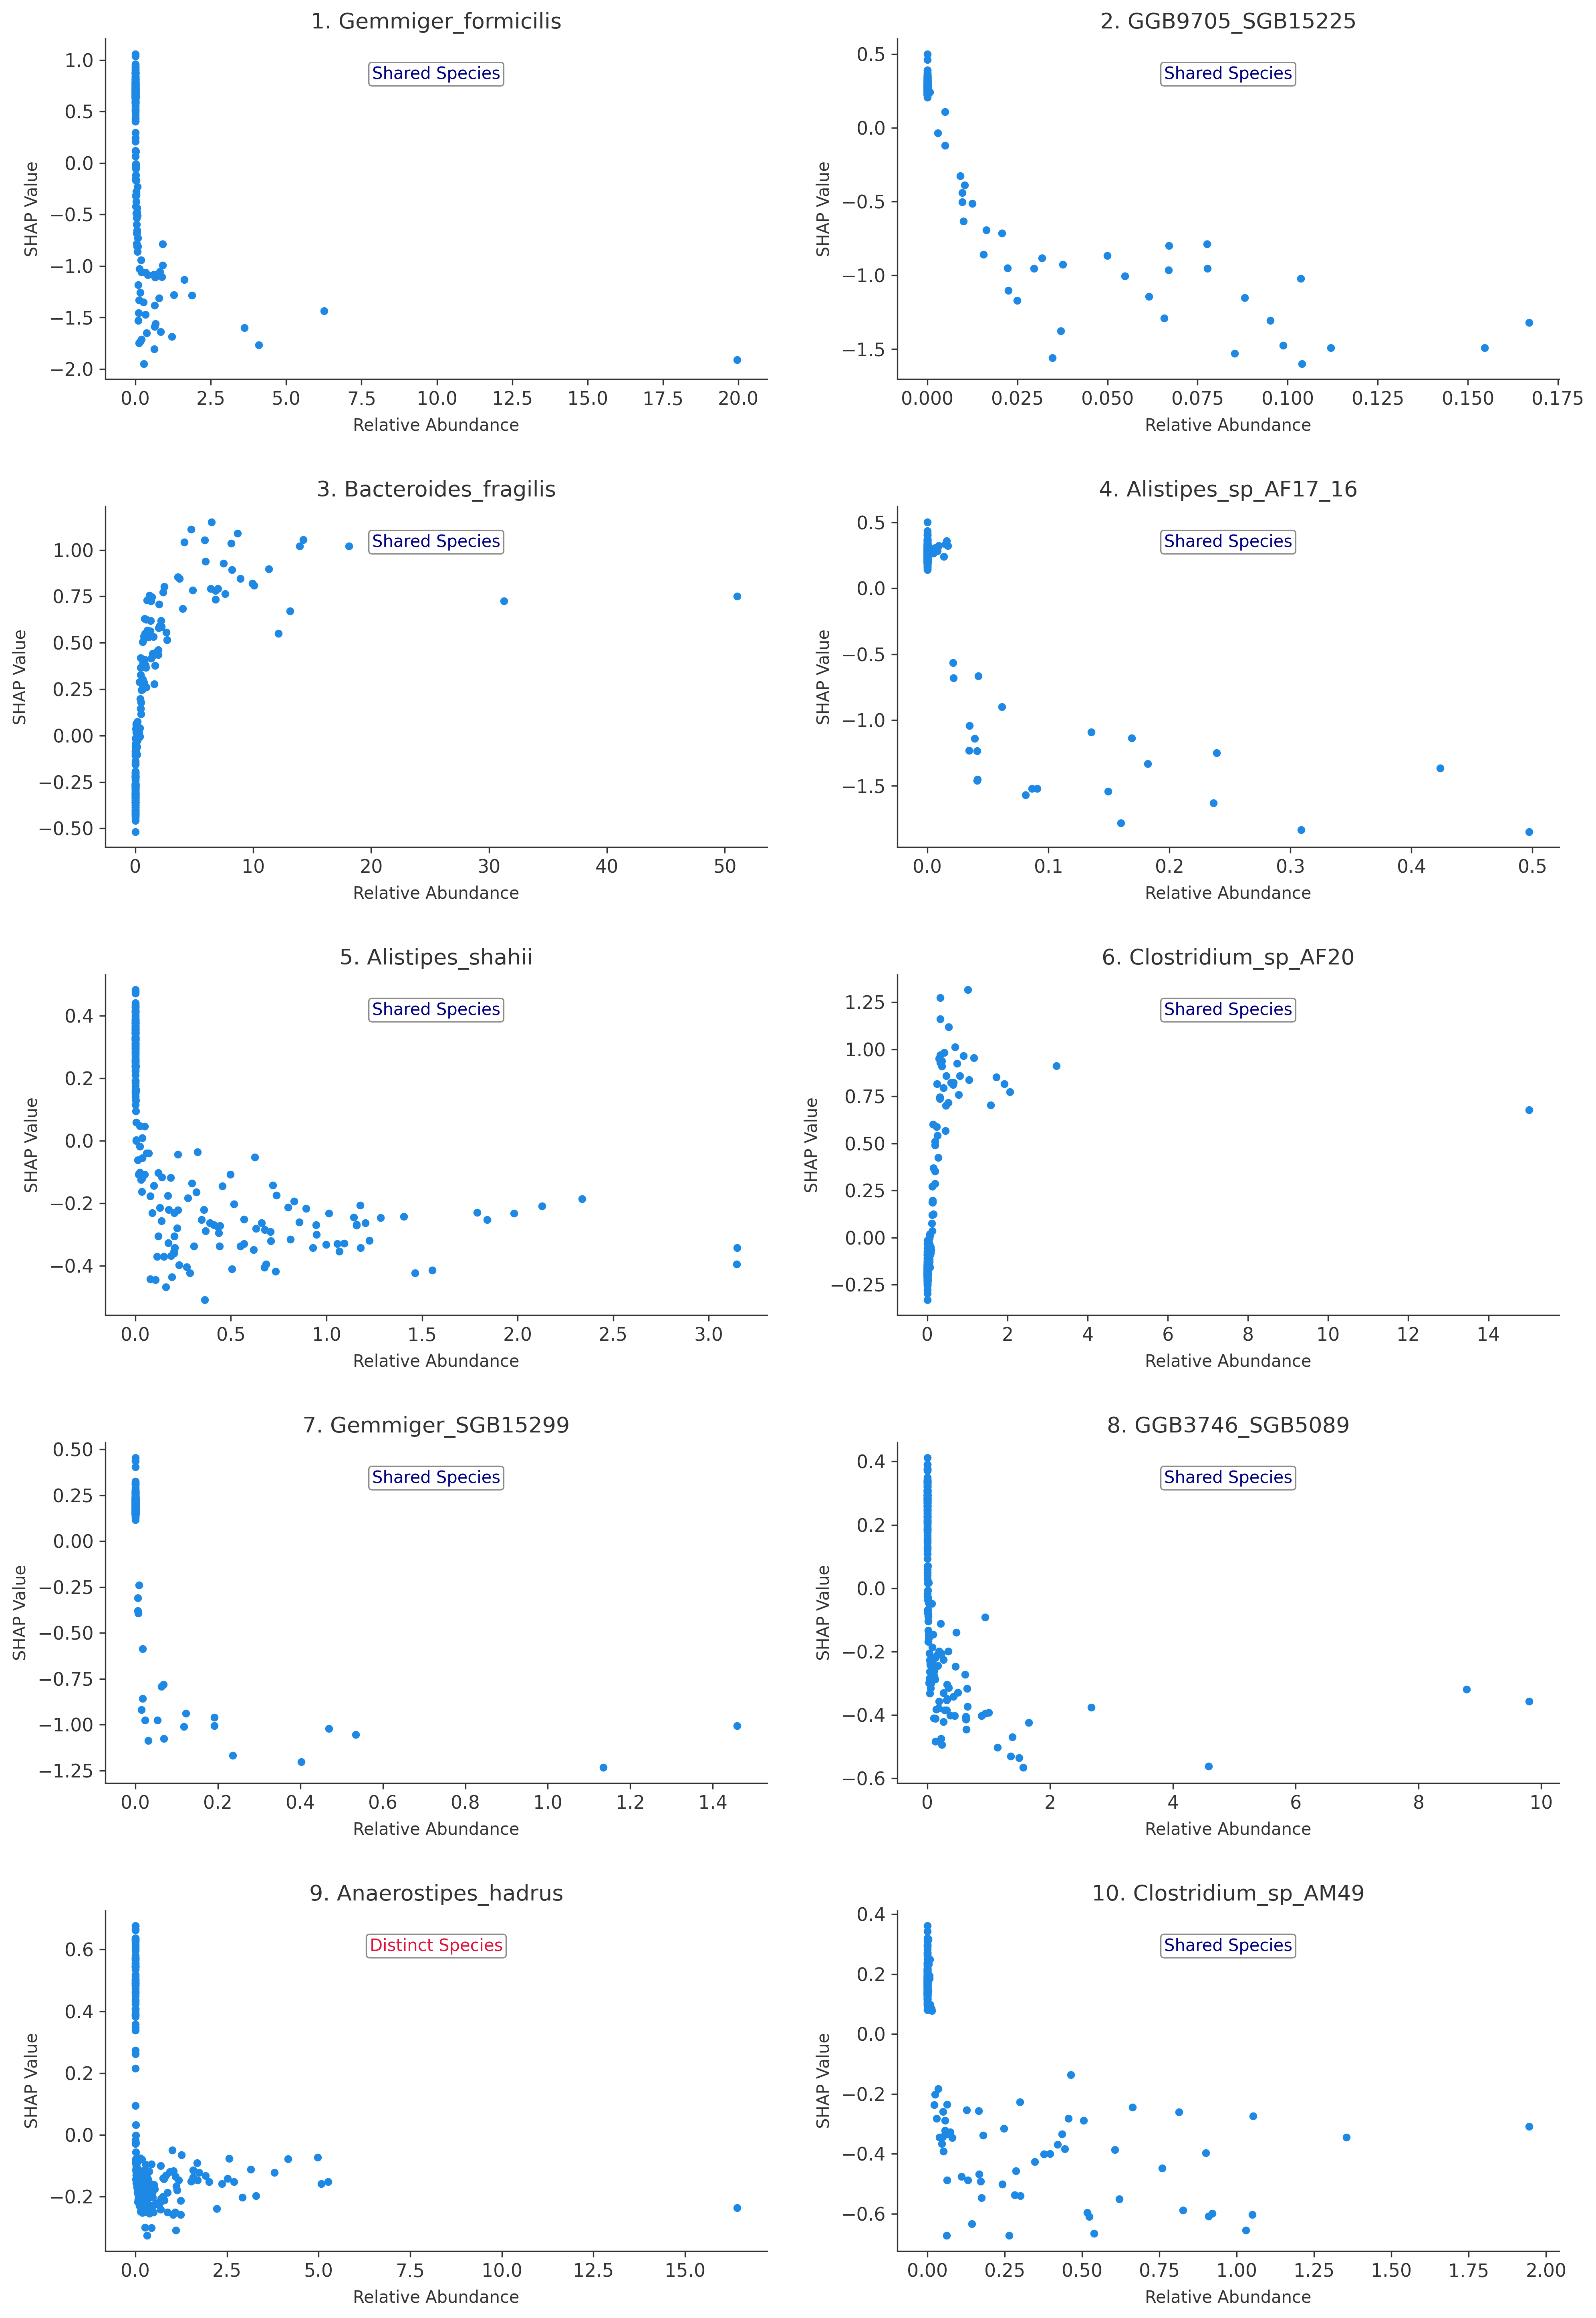

In [ ]:
# Generate a detailed dependency graph for the top 10 features
top10_features = importance_df['feature'].head(10).tolist()

# Modified SHAP dependency graph code
plt.figure(figsize=(14, 20))  # Increase canvas height
plt.rcParams.update({'font.size': 11, 'axes.labelpad': 5})

for i, feature in enumerate(top10_features, 1):
    ax = plt.subplot(5, 2, i)

    # Optimize color mapping logic
    cmap = plt.cm.Reds if feature in distinct_species_list else plt.cm.Blues

    # Dependency mapping
    shap.dependence_plot(
        feature,
        shap_values.values,
        X_test,
        interaction_index=None,
        ax=ax,
        title=f"{i}. {feature[:20]}".rstrip('_'),  # Truncated long name
        cmap=cmap,
        dot_size=22,
        show=False
    )

    # Dynamic adjustment of axes
    ax.set_xlabel("Relative Abundance", fontsize=10)
    ax.set_ylabel("SHAP Value", fontsize=10)

    # Update tag position (centered below title)
    label_y_position = 0.92  # Located below the title (standardized coordinates)
    bbox_props = dict(boxstyle="round,pad=0.2", fc="white", ec="grey", lw=0.8, alpha=0.9)

    if feature in distinct_species_list:
        ax.text(0.5, label_y_position, 'Distinct Species',
               color='crimson', fontsize=10,
               ha='center', va='top',  # Horizontally centered, vertically top-aligned
               transform=ax.transAxes,  # Using a relative coordinate system
               bbox=bbox_props)
    elif feature in shared_species_list:
        ax.text(0.5, label_y_position, 'Shared Species',
               color='navy', fontsize=10,
               ha='center', va='top',
               transform=ax.transAxes,
               bbox=bbox_props)

# Enhanced layout control
plt.tight_layout(pad=3.0, h_pad=2.5, w_pad=2.0)
plt.savefig("/content/drive/MyDrive/code/IBD/2stage/stage1/SHAP_dependence_top10_features.png", dpi=300, bbox_inches='tight')
plt.show()


The following key messages emerge from this set of SHAP dependency maps.
Distinct Species and Common Species have different patterns of influence.
Distinct Species usually show monotonic positive/negative correlations, such as Phocaeicola vulgatus and Faecalibacterium prausnitzii, suggesting that changes in the abundance of these strains have a more direct effect on model predictions.
Shared Species, on the other hand, tended to show bidirectional effects, as in the case of Lachnospiraceae_bacterium and Bacteroides ovatus, which may reflect the complex interactions of these groups of bacteria in the gut ecology.
The strength of the effect varied among the key characters.
Phocaeicola vulgatus and Parabacteroides distasonis had higher SHAP values, indicating that they contributed more to the model predictions.
Eubacterium rectale and Clostridiium sp AM33_3 had relatively small SHAP values, indicating that they had a weaker role in the model.
Some characters showed significant nonlinear effects.
Faecalibacterium prausnitzii had the highest SHAP values in the moderate abundance interval (10-20%), i.e. there was an abundance threshold effect.
Bacteroides xylanisolvens was positively correlated in the low abundance interval and turned negatively correlated in the high abundance interval, reflecting its complex role in gut ecological balance.
Overall, these SHAP dependency maps revealed the mechanisms of different bacterial genera in disease prediction models, providing important insights for subsequent biological interpretation and feature engineering.

Translated with www.DeepL.com/Translator (free version)

# =============== Optimal model a posteriori feature selection ===============

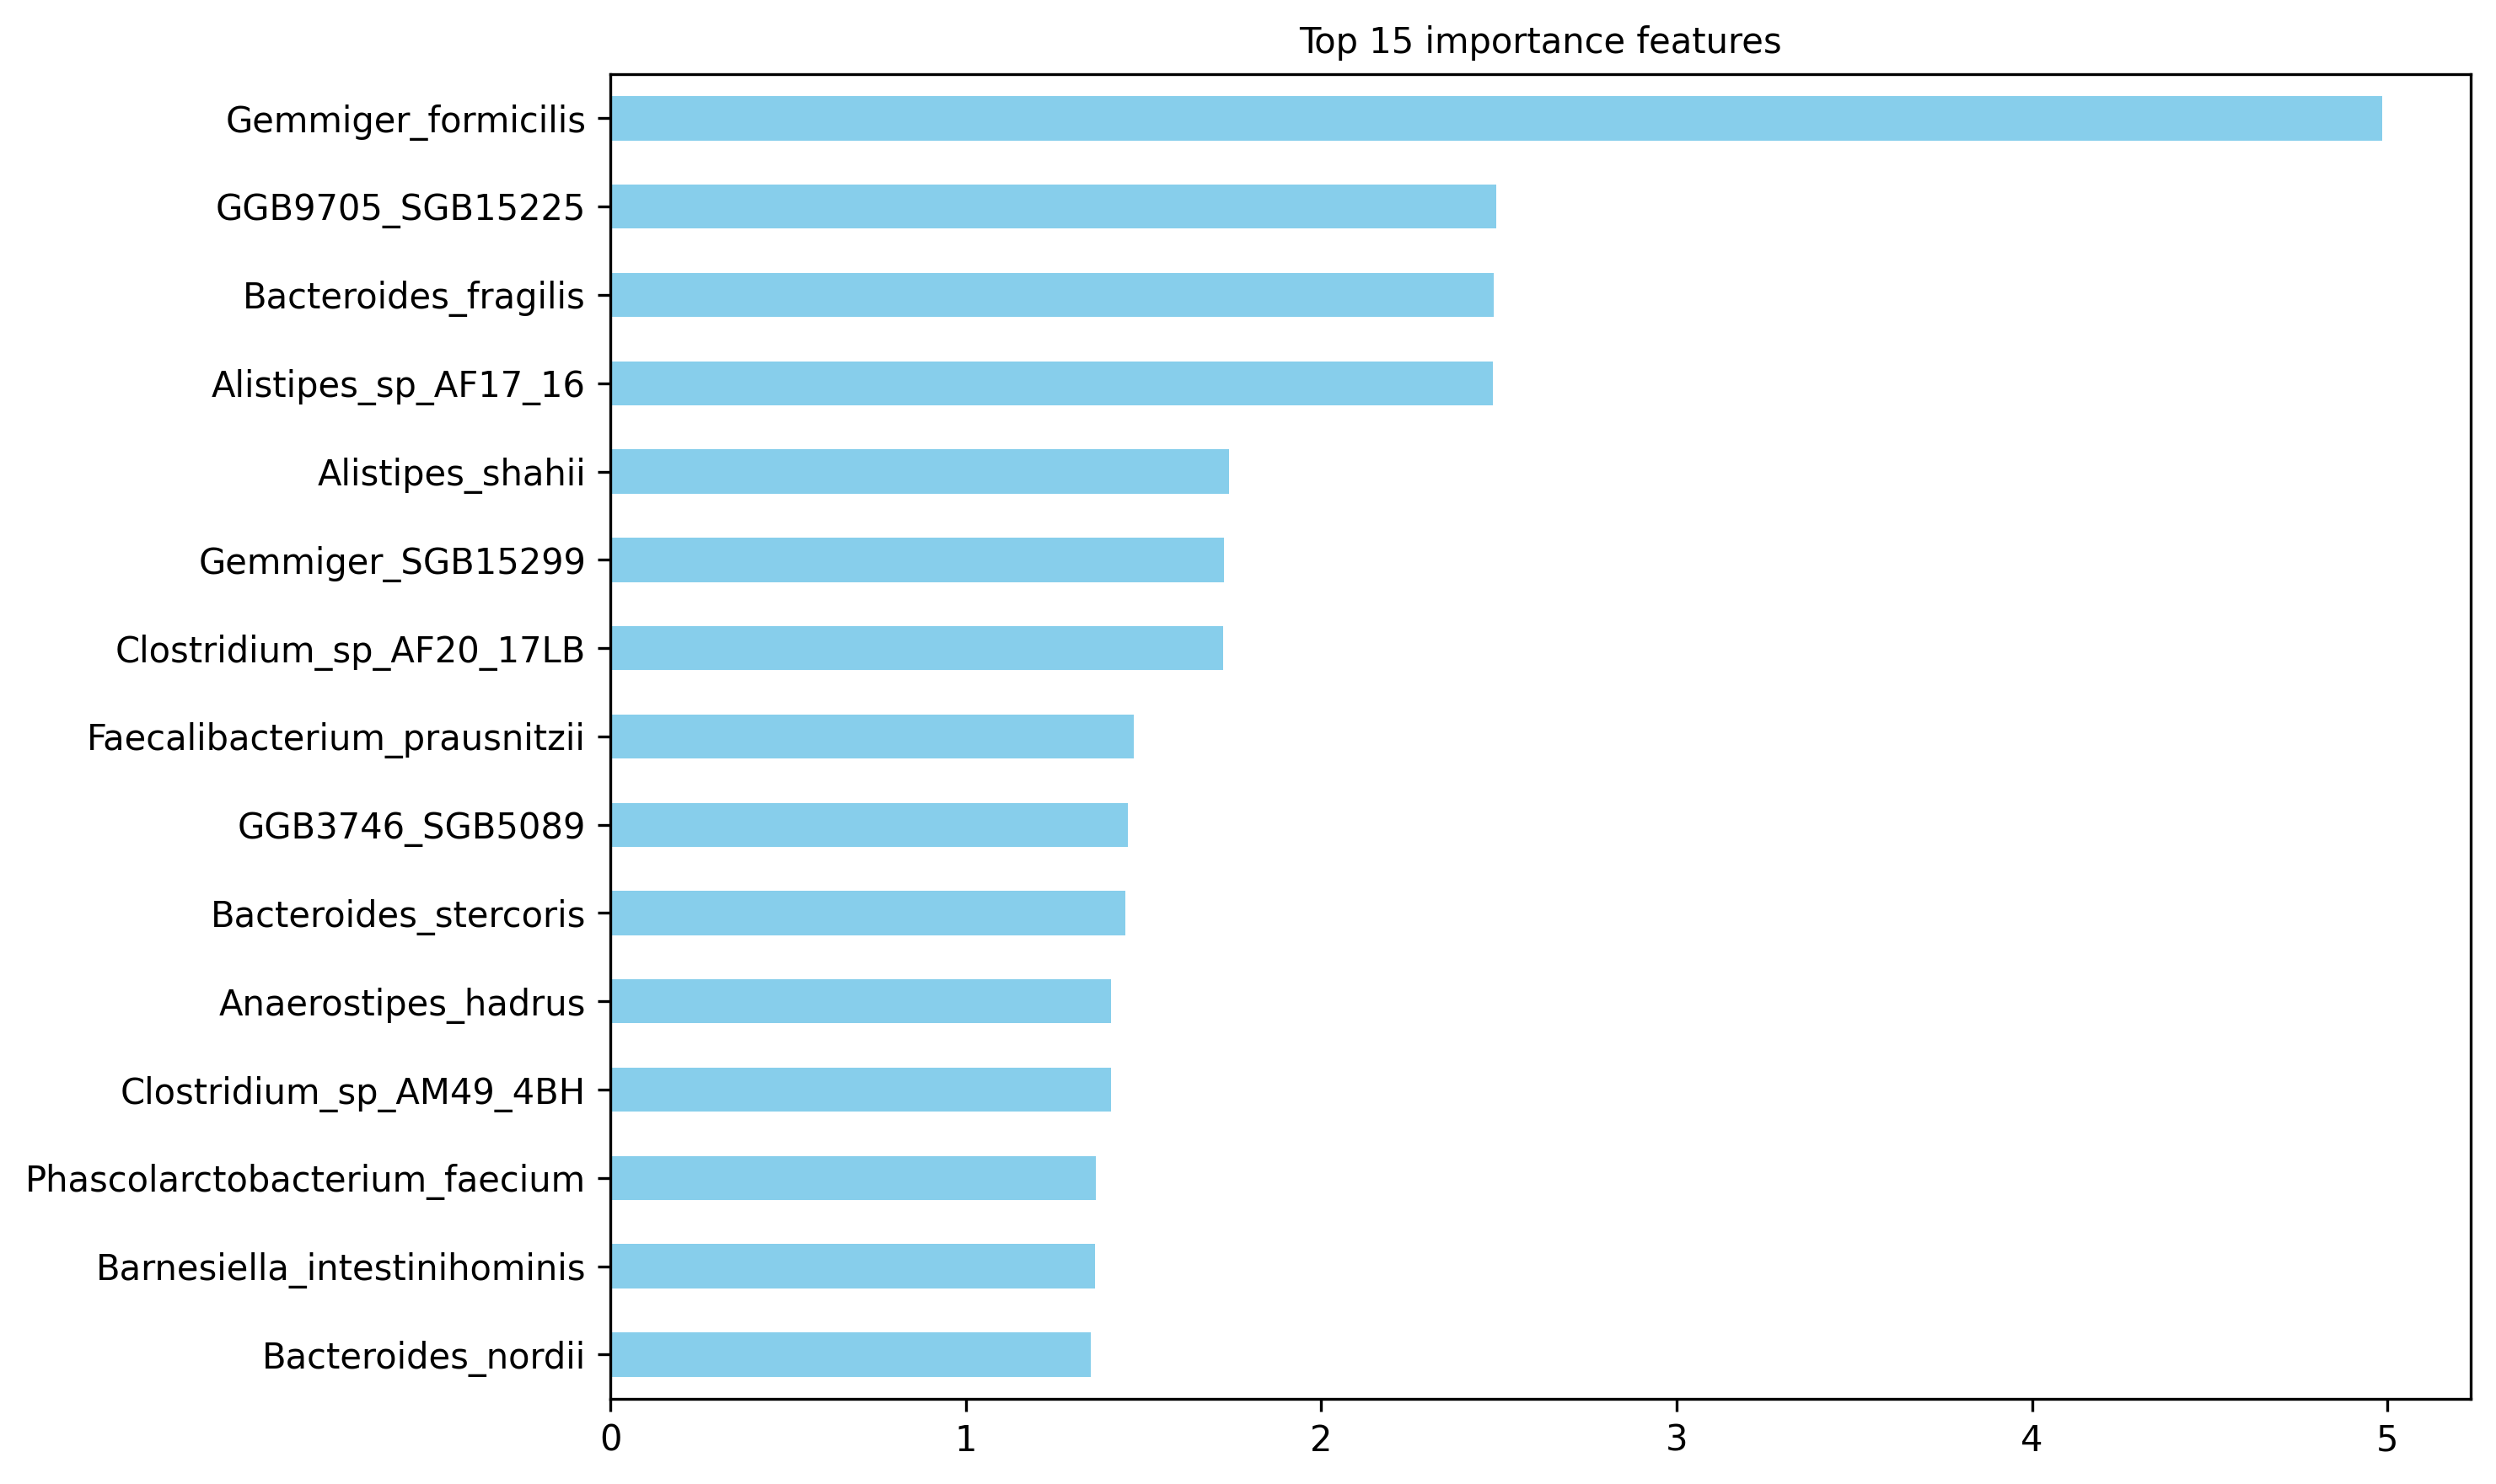

In [ ]:
# Modified Visualization of Characteristic Importance
if hasattr(best_model, 'feature_importances_'):
    try:
        plt.figure(figsize=(10, 6))

        # Dynamic acquisition of the number of features
        num_features = best_model.n_features_in_

        # Generate the correct feature name
        try:
            feature_names = X.columns.tolist()[:num_features]  # Use real data column names
        except Exception:
            feature_names = [f"Feature_{i:03d}" for i in range(num_features)]  # dynamically generated

        # Create a sequence of feature importance
        feat_imp = pd.Series(
            best_model.feature_importances_,
            index=feature_names
        )

        # Filter and visualize
        feat_imp = feat_imp[feat_imp > 0].sort_values(ascending=False)
        if not feat_imp.empty:
            feat_imp.head(15).sort_values().plot.barh(color='skyblue')
            plt.title(f'Top {min(15,len(feat_imp))} importance features')
            plt.tight_layout()
            plt.savefig('/content/drive/MyDrive/code/IBD/2stage/stage1/feature_importance.png', dpi=300)
            plt.show()
        else:
            print(f"[{best_model_name}] Valid feature importance not detected")
    except Exception as e:
        print(f"Failure of feature importance analysis: {str(e)}")

In [ ]:
# === A posteriori feature optimization system ===
# Inputs: full model, SHAP importance data frame, raw data
def post_hoc_feature_selection(model, importance_df, X_full, y_full, top_n=30, stability_threshold=0.8):
    """
    Dynamic selection system based on feature importance

    parameters：
    model : Trained optimal model
    importance_df : Data frame with 'feature' and 'importance' columns
    X : primitive identity matrix (math.)
    y : target variable
    top_n : Number of initial sieve features
    stability_threshold : Feature Stability Threshold
    """
    # Checking Input Integrity
    assert isinstance(X_full, pd.DataFrame), "X_full must be DataFrame"
    assert X_full.shape[0] == len(y_full), f"Sample size mismatch X:{X_full.shape[0]} vs y:{len(y_full)}"

    # Stage 1: Initial screening
    primary_features = importance_df.head(top_n)['feature'].tolist()
    X_primary = X_full[primary_features]

    # Phase 2: Stability Validation
    stability_scores = bootstrap_feature_stability(model, X_primary, y_full)
    stable_features = [f for f, s in zip(primary_features, stability_scores)
                      if s >= stability_threshold]

    # Phase 3: Performance Verification
    X_stable = X_full[stable_features]
    final_features = validate_feature_performance(model, X_full, X_stable, y_full)

    return final_features

def bootstrap_feature_stability(model, X, y, n_samples=50):
    """Stability test after accelerated treatment"""
    feature_counts = pd.Series(0, index=X.columns)
    for _ in range(n_samples):
        X_res, y_res = resample(X, y, stratify=y)
        model_clone = clone(model).fit(X_res, y_res)

        explainer = shap.TreeExplainer(model_clone)
        shap_values = explainer.shap_values(X_res)
        if isinstance(shap_values, list):
            imp = np.abs(shap_values[1]).mean(0)  # Orthoclasses of the dichotomy
        else:
            imp = np.abs(shap_values).mean(0)

        top_features = pd.Series(imp, index=X.columns).nlargest(20).index
        feature_counts[top_features] +=1

    return feature_counts / n_samples

def validate_feature_performance(model, X_full, X_subset, y, cv=3):
    """Optimized performance validation"""
    assert X_full.shape[0] == X_subset.shape[0], "Sample size must be consistent"

    base_score = cross_val_score(model, X_full, y, cv=cv, n_jobs=-1).mean()
    subset_score = cross_val_score(model, X_subset, y, cv=cv, n_jobs=-1).mean()

    print(f"[Performance Comparison] Full Features: {base_score:.4f} | subset of features (math.): {subset_score:.4f}")
    return X_subset.columns.tolist() if subset_score >= base_score * 0.95 else X_full.columns.tolist()

# usage example -------------------------------------------------
print(f"Raw feature count: {X_train.shape[1]}")
final_features = post_hoc_feature_selection(
    best_model,
    importance_df,
    X_train,
    y_train,
    top_n=30
)
print(f"Number of final screening features: {len(final_features)}")

原始特征数: 216
【性能对比】完整特征: 0.8833 | 特征子集: 0.8512
最终筛选特征数: 20



=== 性能对比报告 ===
+--------+---------------------+---------------------+
| 指标   | 原模型              | 精简模型            |
+========+=====================+=====================+
| AUC    | 0.940 (0.906-0.968) | 0.872 (0.829-0.916) |
+--------+---------------------+---------------------+
| 准确率 | 0.876               | 0.831               |
+--------+---------------------+---------------------+
| 精确率 | 0.888               | 0.858               |
+--------+---------------------+---------------------+
| 召回率 | 0.932               | 0.895               |
+--------+---------------------+---------------------+
| F1分数 | 0.910               | 0.876               |
+--------+---------------------+---------------------+


Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) DejaVu Sans.
Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
Glyph 33021 (\N{CJK UNIFIED IDEOGRAPH-80FD}) missing from font(s) DejaVu Sans.
Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) DejaVu Sans.
Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
Glyph 31934 (\N{CJK UNIFIED IDEOGRAPH-7CBE}) missing from font(s) DejaVu Sans.
Glyph 31616 (\N{CJK UNIFIED IDEOGRAPH-7B80}) missing from font(s) DejaVu Sans.


['/content/drive/MyDrive/code/IBD/2stage/stage1/IBD_vs_HC_pruned_model.pkl']

Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) DejaVu Sans.
Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
Glyph 33021 (\N{CJK UNIFIED IDEOGRAPH-80FD}) missing from font(s) DejaVu Sans.
Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) DejaVu Sans.
Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
Glyph 31934 (\N{CJK UNIFIED IDEOGRAPH-7CBE}) missing from font(s) DejaVu Sans.
Glyph 31616 (\N{CJK UNIFIED IDEOGRAPH-7B80}) missing from font(s) DejaVu Sans.


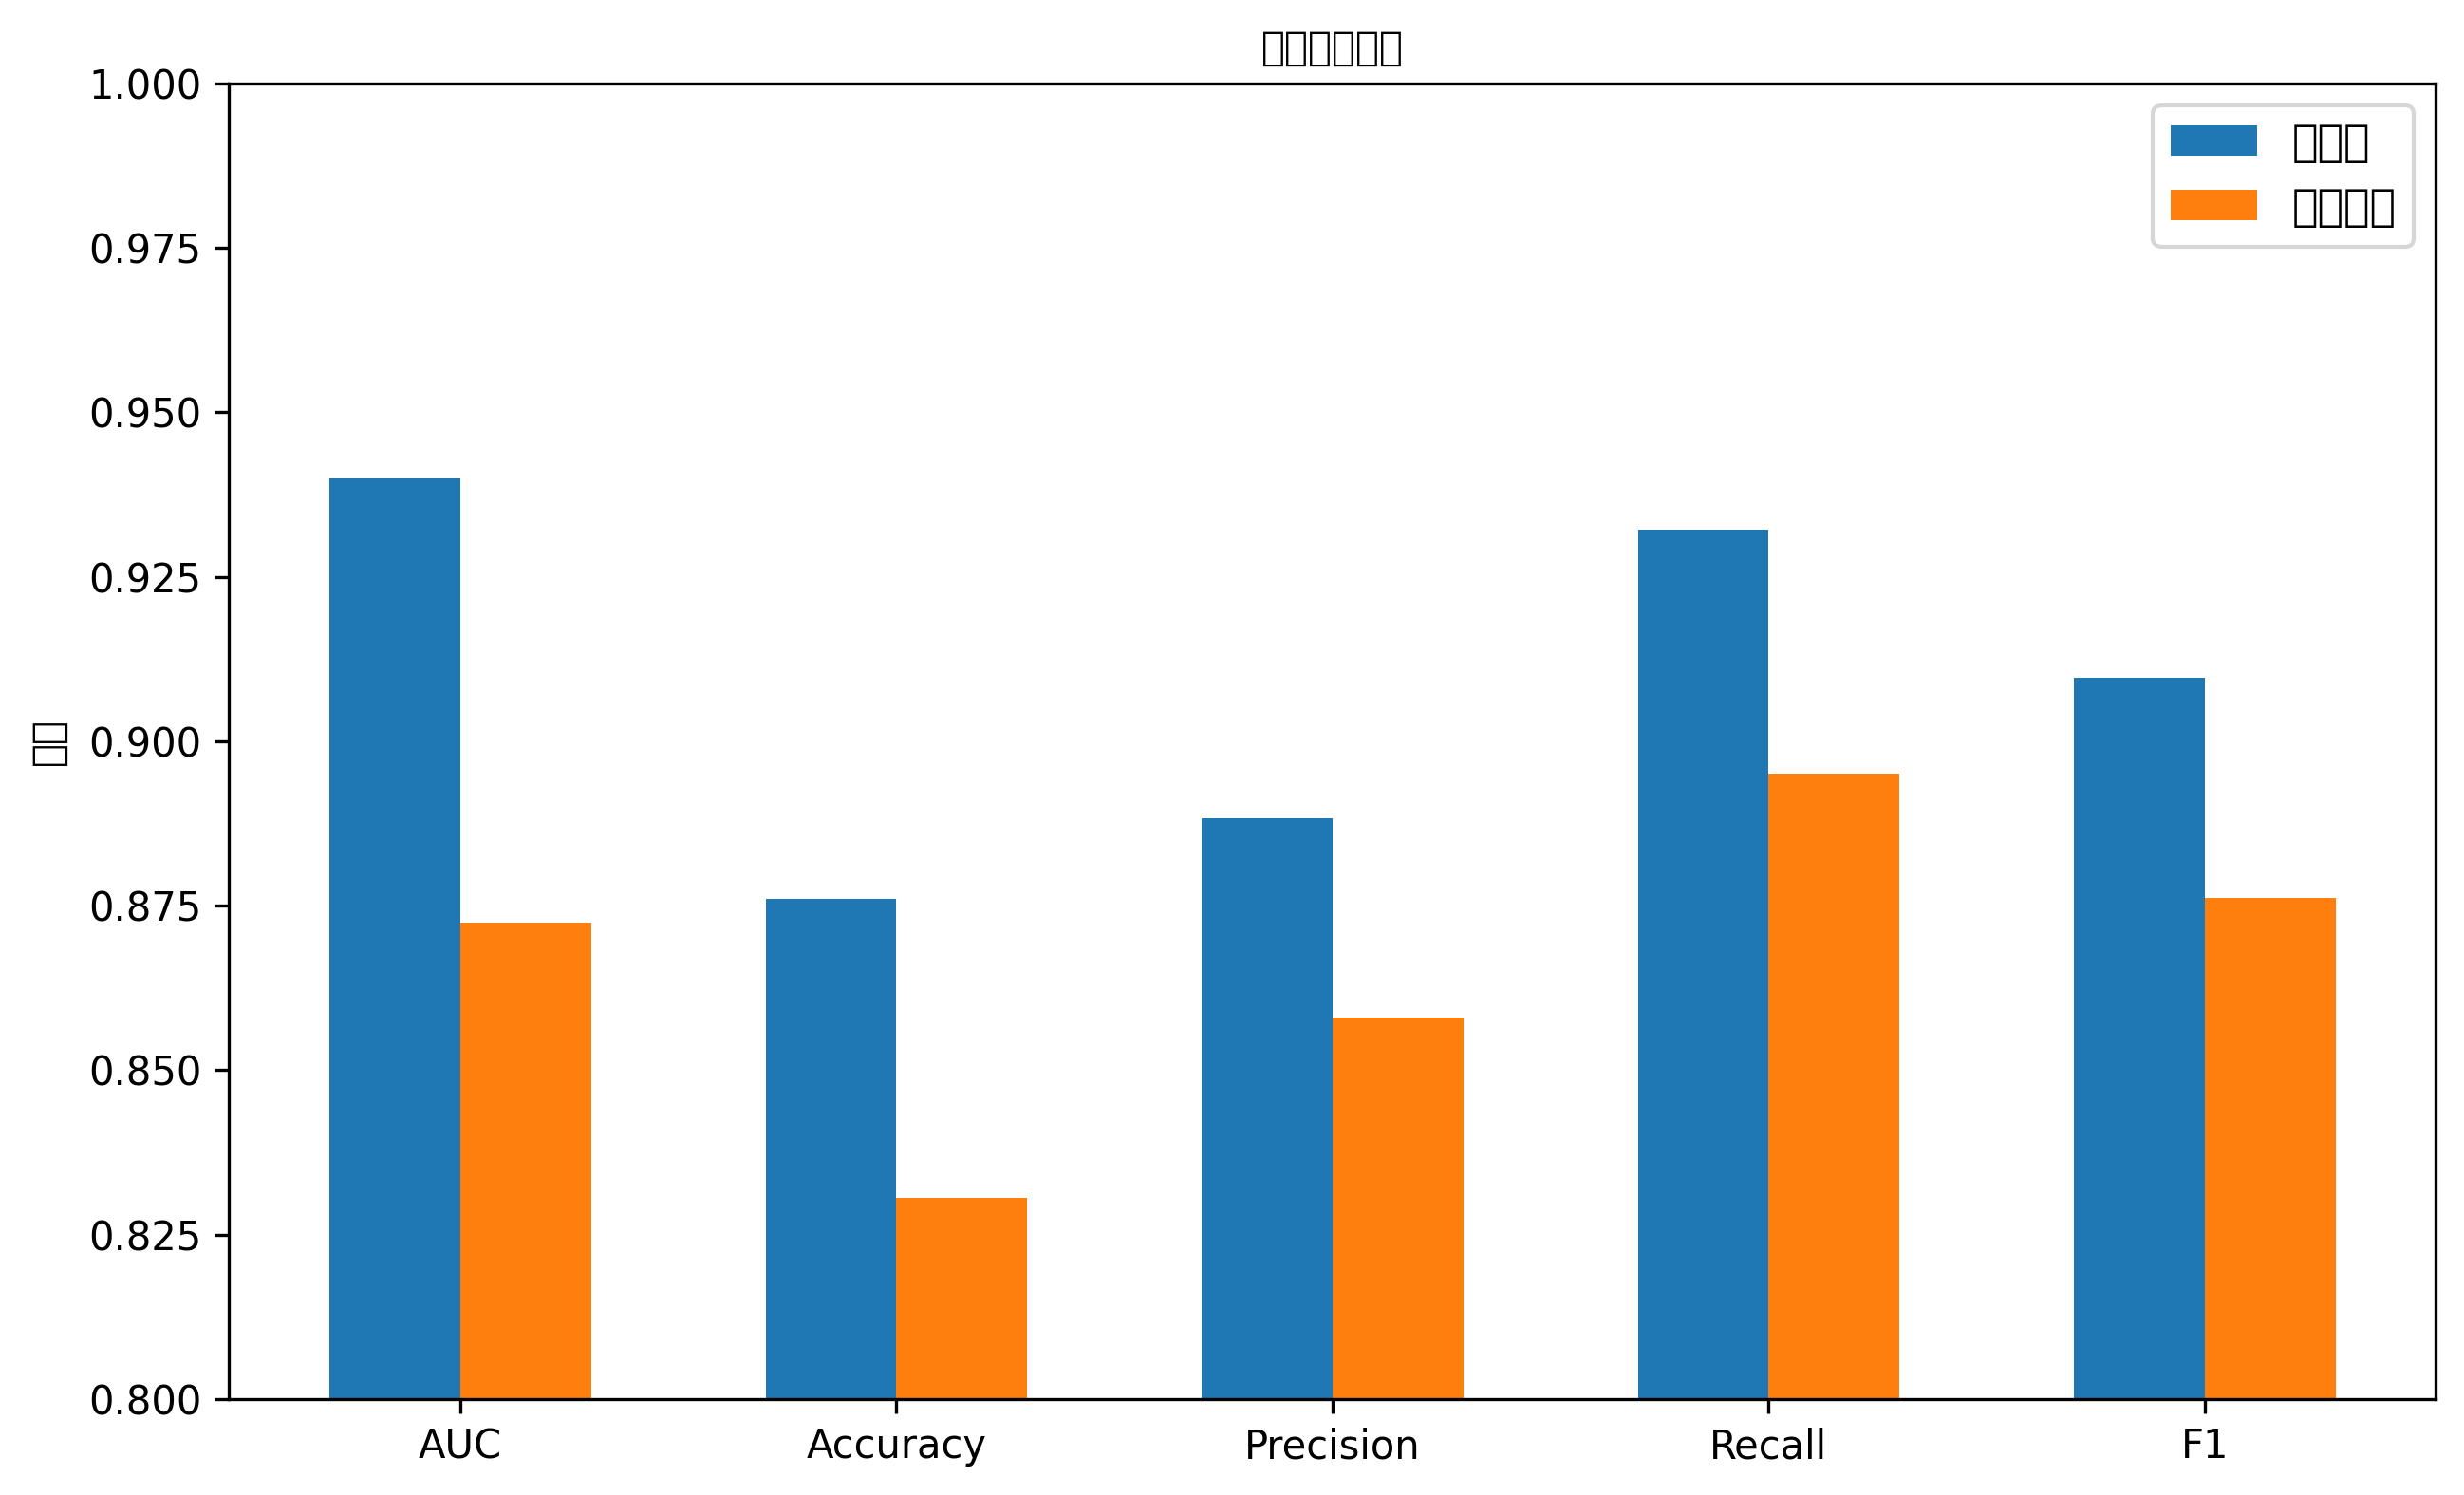

In [ ]:
# === core function ===
def calculate_auc_ci(y_true, y_proba, confidence=0.95):
    """Harmonized calculation of AUC and its confidence intervals"""
    n = len(y_true)
    auc = roc_auc_score(y_true, y_proba)
    slices = [roc_auc_score(y_true[:i], y_proba[:i])
             for i in range(100, n, 100)]  # Isometric sampling improves efficiency
    std_err = sem(slices)
    h = std_err * t.ppf((1 + confidence)/2, n-1)
    return auc, (max(0, auc-h), min(1, auc+h))

def evaluate_model(model, X, y, features):
    """Harmonization of evaluation functions"""
    assert set(features).issubset(X.columns), f"Missing features: {set(features)-set(X.columns)}"

    y_pred = model.predict(X[features])
    y_proba = model.predict_proba(X[features])[:, 1]

    auc, auc_ci = calculate_auc_ci(y, y_proba)

    return {
        'AUC': auc,
        'AUC_CI': auc_ci,
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred),
        'Recall': recall_score(y, y_pred),
        'F1': f1_score(y, y_pred),
        'Confusion_Matrix': confusion_matrix(y, y_pred)
    }

# === Data preparation ===
# Assume that the following variables already exist：
# - final_features: List of filtered features
# - X_train, y_train: Full training set
# - X_test, y_test: test set
# - best_model: Original full model
# - final_metrics: Initial Evaluation Results DataFrame

# Initializing a streamlined model
pruned_model = clone(best_model.__class__(**best_model.get_params()))

# retrain
pruned_model.fit(
    X_train[final_features],
    y_train,
    eval_set=[(X_test[final_features], y_test)] if hasattr(pruned_model, 'eval_set') else None,
    verbose=False
)

# === Getting raw model performance ===
original_entry = final_metrics.iloc[0]
original_result = {
    'AUC': float(original_entry['AUC (95% CI)'].split()[0]),
    'AUC_CI': tuple(map(float,
                      re.findall(r"\d+\.\d+",
                               original_entry['AUC (95% CI)'])[1:])),
    'Accuracy': original_entry['Accuracy'],
    'Precision': original_entry['Precision'],
    'Recall': original_entry['Recall'],
    'F1': original_entry['F1-Score']
}

# === Evaluation of the streamlined model ===
pruned_result = evaluate_model(
    pruned_model,
    X_test,
    y_test,
    features=final_features
)

# === Generate a comparison report ===
comparison_df = pd.DataFrame({
    'norm': ['AUC', 'accuracy', 'precision', 'recall', 'F1 score'],
    'original model': [
        f"{original_result['AUC']:.3f} ({original_result['AUC_CI'][0]:.3f}-{original_result['AUC_CI'][1]:.3f})",
        f"{original_result['Accuracy']:.3f}",
        f"{original_result['Precision']:.3f}",
        f"{original_result['Recall']:.3f}",
        f"{original_result['F1']:.3f}"
    ],
    'Compact model': [
        f"{pruned_result['AUC']:.3f} ({pruned_result['AUC_CI'][0]:.3f}-{pruned_result['AUC_CI'][1]:.3f})",
        f"{pruned_result['Accuracy']:.3f}",
        f"{pruned_result['Precision']:.3f}",
        f"{pruned_result['Recall']:.3f}",
        f"{pruned_result['F1']:.3f}"
    ]
})

print("\n=== Performance Comparison Report ===")
print(comparison_df.to_markdown(index=False, tablefmt="grid"))

# === Visualization Comparison ===
plt.figure(figsize=(10,6))
metrics = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1']
x = np.arange(len(metrics))

# data conversion
original_values = [
    original_result['AUC'],
    original_result['Accuracy'],
    original_result['Precision'],
    original_result['Recall'],
    original_result['F1']
]
pruned_values = [
    pruned_result['AUC'],
    pruned_result['Accuracy'],
    pruned_result['Precision'],
    pruned_result['Recall'],
    pruned_result['F1']
]

plt.bar(x - 0.15, original_values, width=0.3, label='original model')
plt.bar(x + 0.15, pruned_values, width=0.3, label='Compact model')
plt.xticks(x, metrics)
plt.ylabel('numerical value')
plt.ylim(0.8, 1.0)
plt.title('Model Performance Comparison')
plt.legend()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')

# === Model saving ===
model_package = {
    'model': pruned_model,
    'features': final_features,
    'performance': {
        'original': original_result,
        'pruned': pruned_result
    },
    'metadata': {
        'samples': {
            'train': len(y_train),
            'test': len(y_test)
        },
        'feature_counts': {
            'original': X_train.shape[1],
            'pruned': len(final_features)
        }
    }
}

joblib.dump(
    model_package,
    '/content/drive/MyDrive/code/IBD/2stage/stage1/IBD_vs_HC_pruned_model.pkl'
)


Performing SHAP analysis for model interpretability...

Generating custom-colored SHAP bar plot...

Generating SHAP beeswarm plot with consistent colors...


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


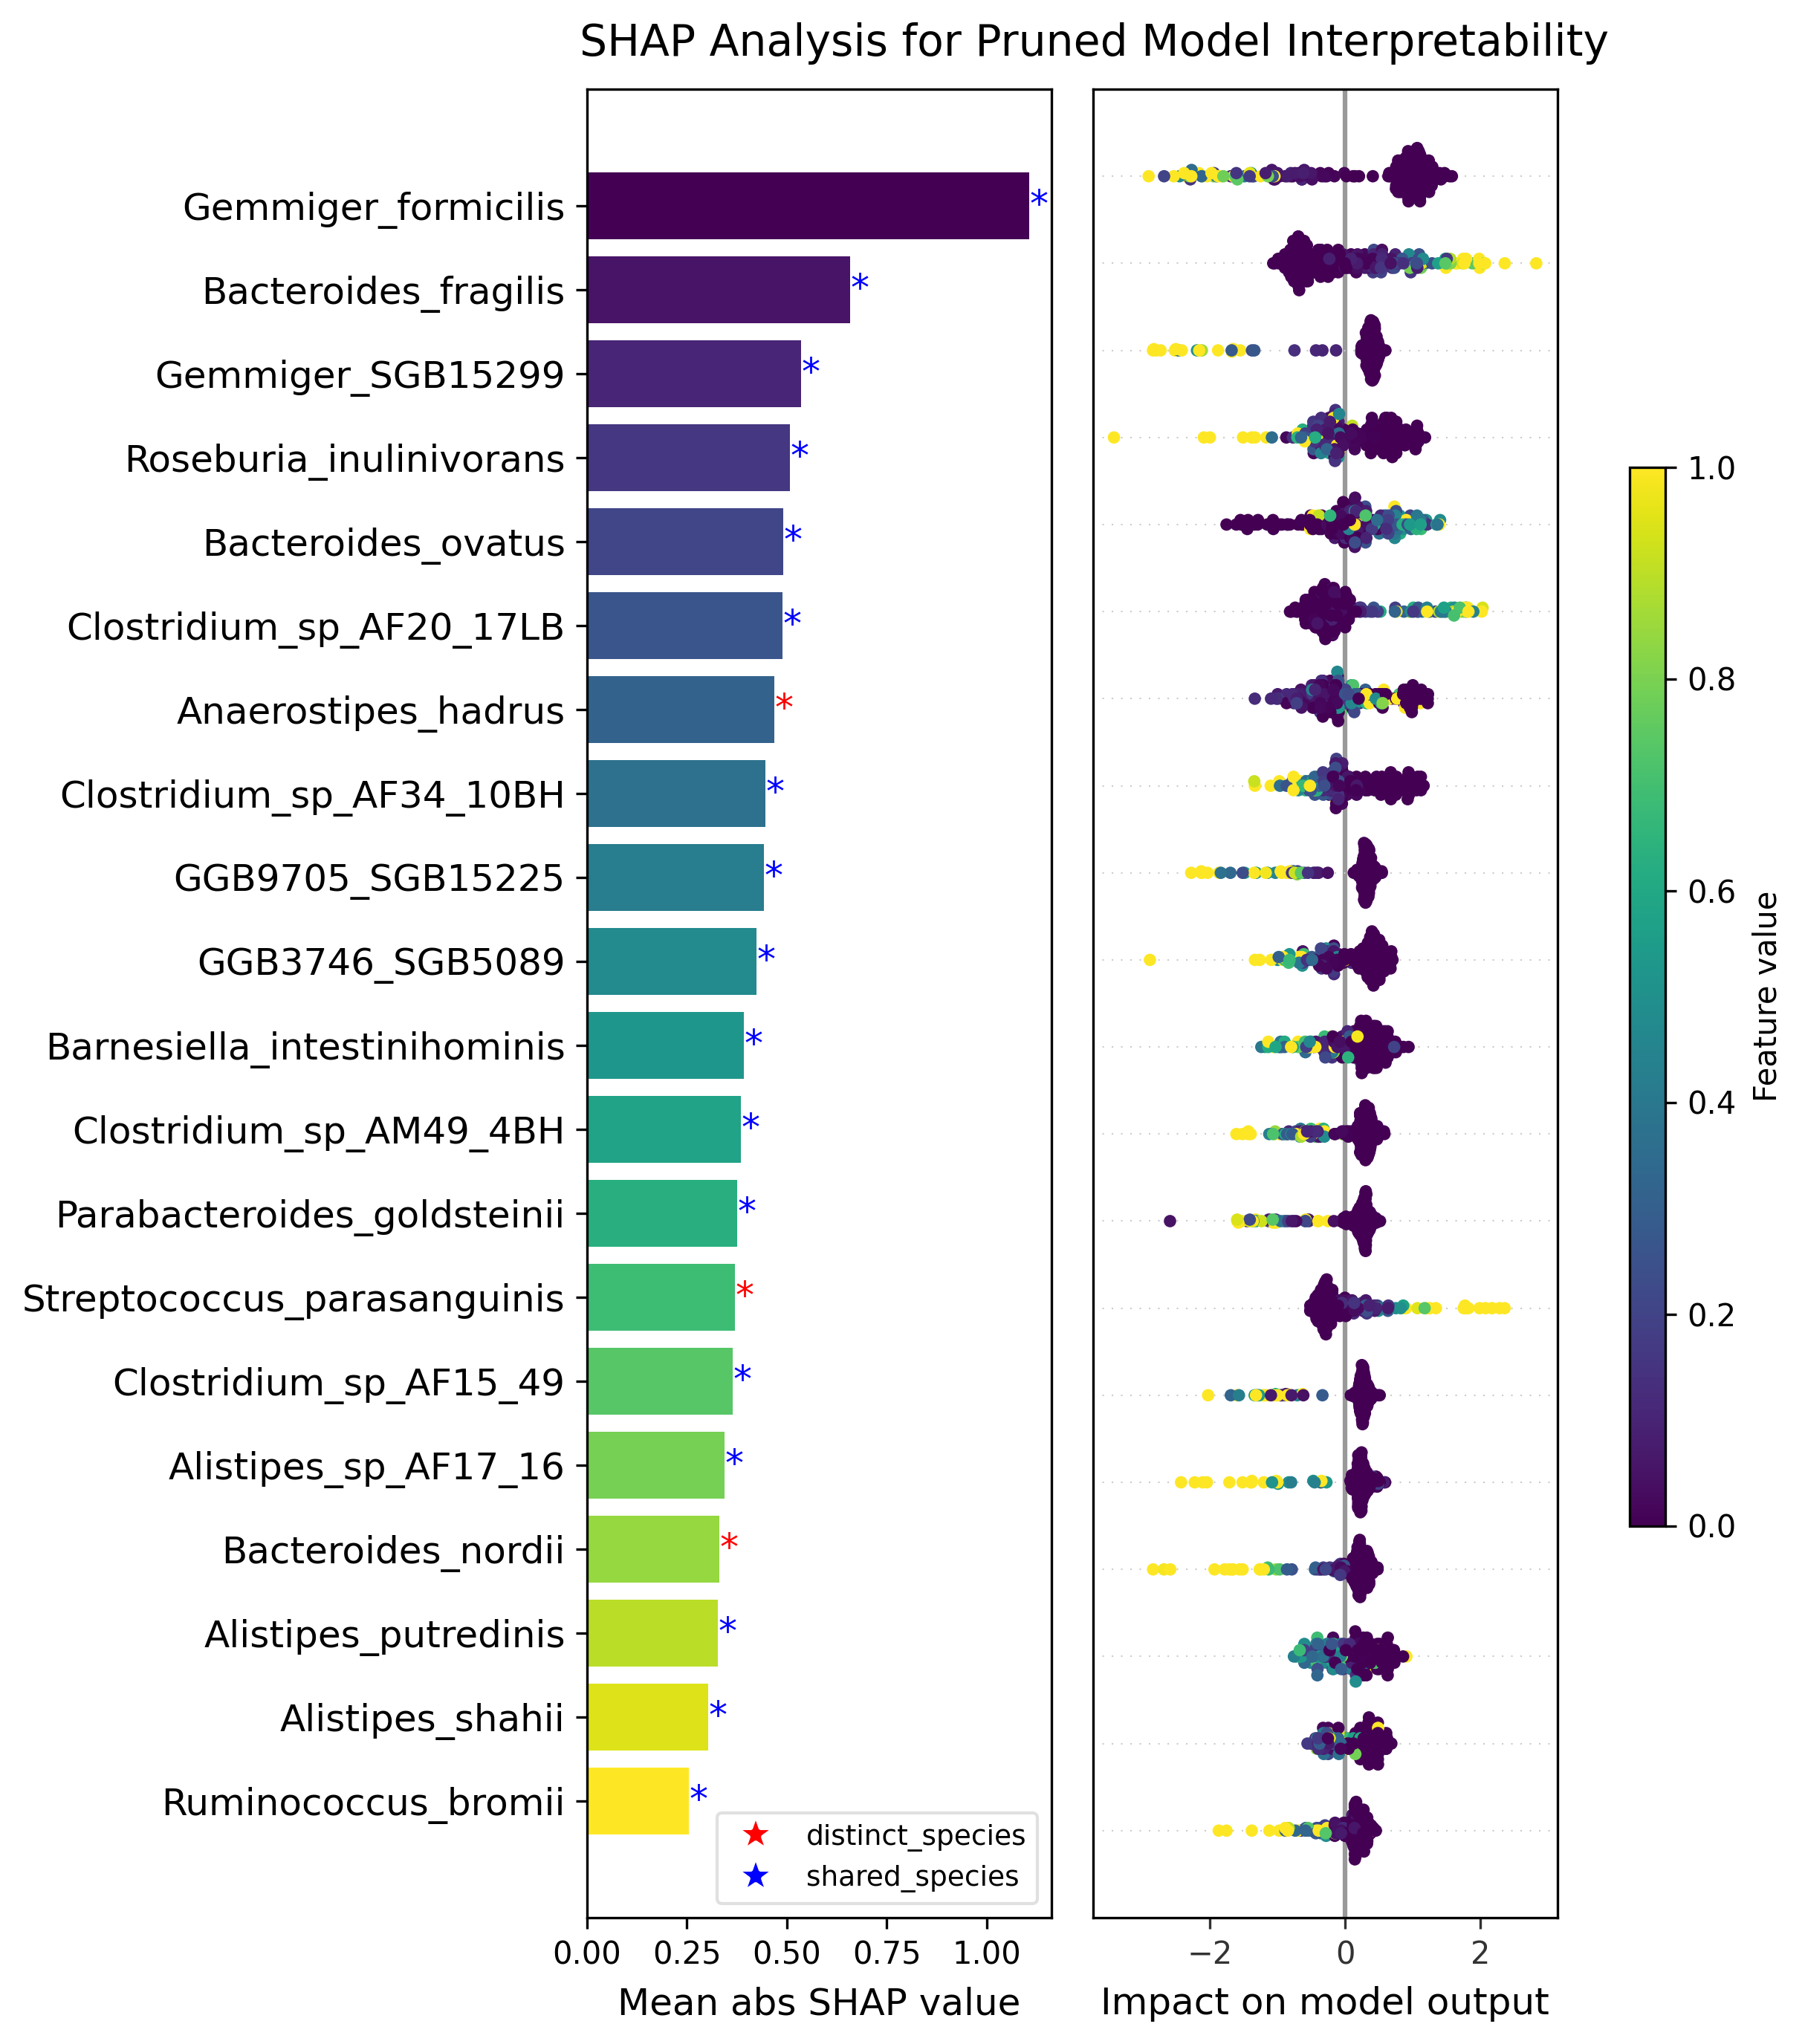

In [ ]:
# Set font for all plots
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 10  # Global font size for readability
plt.rcParams['axes.titlesize'] = 10  # Title font size
plt.rcParams['axes.labelsize'] = 10  # Axis label font size
plt.rcParams['xtick.labelsize'] = 10  # X-tick label size
plt.rcParams['ytick.labelsize'] = 10  # Y-tick label size

# SHAP Analysis for model interpretability
print("\nPerforming SHAP analysis for model interpretability...")
explainer = shap.TreeExplainer(pruned_model)

# Generate SHAP values using explainer on X_test[final_features]
shap_values_explanation = explainer(X_test[final_features])
shap_values = shap_values_explanation

# Create figure and set size to align both plots
fig, axes = plt.subplots(1, 2, figsize=(12, 8), dpi=300)
fig.subplots_adjust(wspace=0.6)  # Slightly increase space between the two plots

# 1. Custom-colored SHAP bar plot
print("\nGenerating custom-colored SHAP bar plot...")
mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)
feature_names = X_test[final_features].columns

# Store feature importance in DataFrame and sort by importance
importance_df = pd.DataFrame({'feature': feature_names, 'importance': mean_abs_shap_values})
importance_df = importance_df.sort_values(by='importance', ascending=False).head(20)

# Custom colors
colors = plt.cm.viridis(np.linspace(0, 1, len(importance_df)))

# Plot custom bar plot
axes[0].barh(importance_df['feature'], importance_df['importance'], color=colors)

legend_elements = [
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='red', markersize=12, label='distinct_species'),
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='blue', markersize=12, label='shared_species')
]

axes[0].legend(handles=legend_elements,
              loc='lower right',
              frameon=True,
              framealpha=0.9,
              edgecolor='#DDDDDD',
              title='',
              title_fontsize=10,
              fontsize=9)

axes[0].invert_yaxis()

# Add strain labeling
for i, feature in enumerate(importance_df['feature']):
    if feature in distinct_species_list:
      # Add a red star for distinct species
        axes[0].text(importance_df['importance'].iloc[i]+0.001, i, '*',
                color='red', fontsize=12, va='center')
    elif feature in shared_species_list:
      # Add a blue star for shared species
        axes[0].text(importance_df['importance'].iloc[i]+0.001, i, '*',
                color='blue', fontsize=12, va='center')

# Hide x-axis label and title by setting them as empty strings
axes[0].set_xlabel("Mean abs SHAP value", fontsize=12)  # Hide x-axis label for the bar plot
axes[0].set_title("")   # Hide title for the bar plot
axes[0].tick_params(axis='y', labelsize=12)  # Increase font size for feature names

# Set consistent x-axis tick parameters for the bar plot
axes[0].tick_params(axis='x', labelsize=10)  # Ensure the x-axis tick size is consistent

# 2. SHAP beeswarm plot with consistent colors
print("\nGenerating SHAP beeswarm plot with consistent colors...")
plt.sca(axes[1])
shap.summary_plot(shap_values, X_test[final_features], plot_type="dot", max_display=20, show=False, color_bar=False, cmap="viridis")
axes[1].tick_params(labelleft=False)
axes[1].tick_params(left=False)
axes[1].set_title("")   # Hide title for beeswarm plot
axes[1].set_xlabel("Impact on model output", fontsize=12)  # Hide x-axis label for beeswarm plot
axes[1].spines[['left', 'right', 'top']].set_visible(True)

# Set consistent x-axis tick parameters for the beeswarm plot
axes[1].tick_params(axis='x', labelsize=10)  # Ensure the x-axis tick size is consistent

# Add a color bar next to the beeswarm plot with adjusted size
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])  # Adjusted color bar position and size
sm = plt.cm.ScalarMappable(cmap="viridis")
sm.set_array([])
plt.colorbar(sm, cax=cbar_ax, label="Feature value", orientation='vertical')

# Adjust layout and save image with high resolution
# Add before plt.tight_layout()
fig.suptitle('SHAP Analysis for Pruned Model Interpretability',
            x=0.62,  # Precise horizontal positioning
            y=0.96,  # Precise vertical positioning
            fontsize=14,
            fontweight='normal')
# Adjusting the layout to reserve header space
plt.tight_layout(rect=[0, 0, 0.9, 0.98])  # Reserve top 5% space
plt.savefig("/content/drive/MyDrive/code/IBD/2stage/stage1/SHAP_pruned_model.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

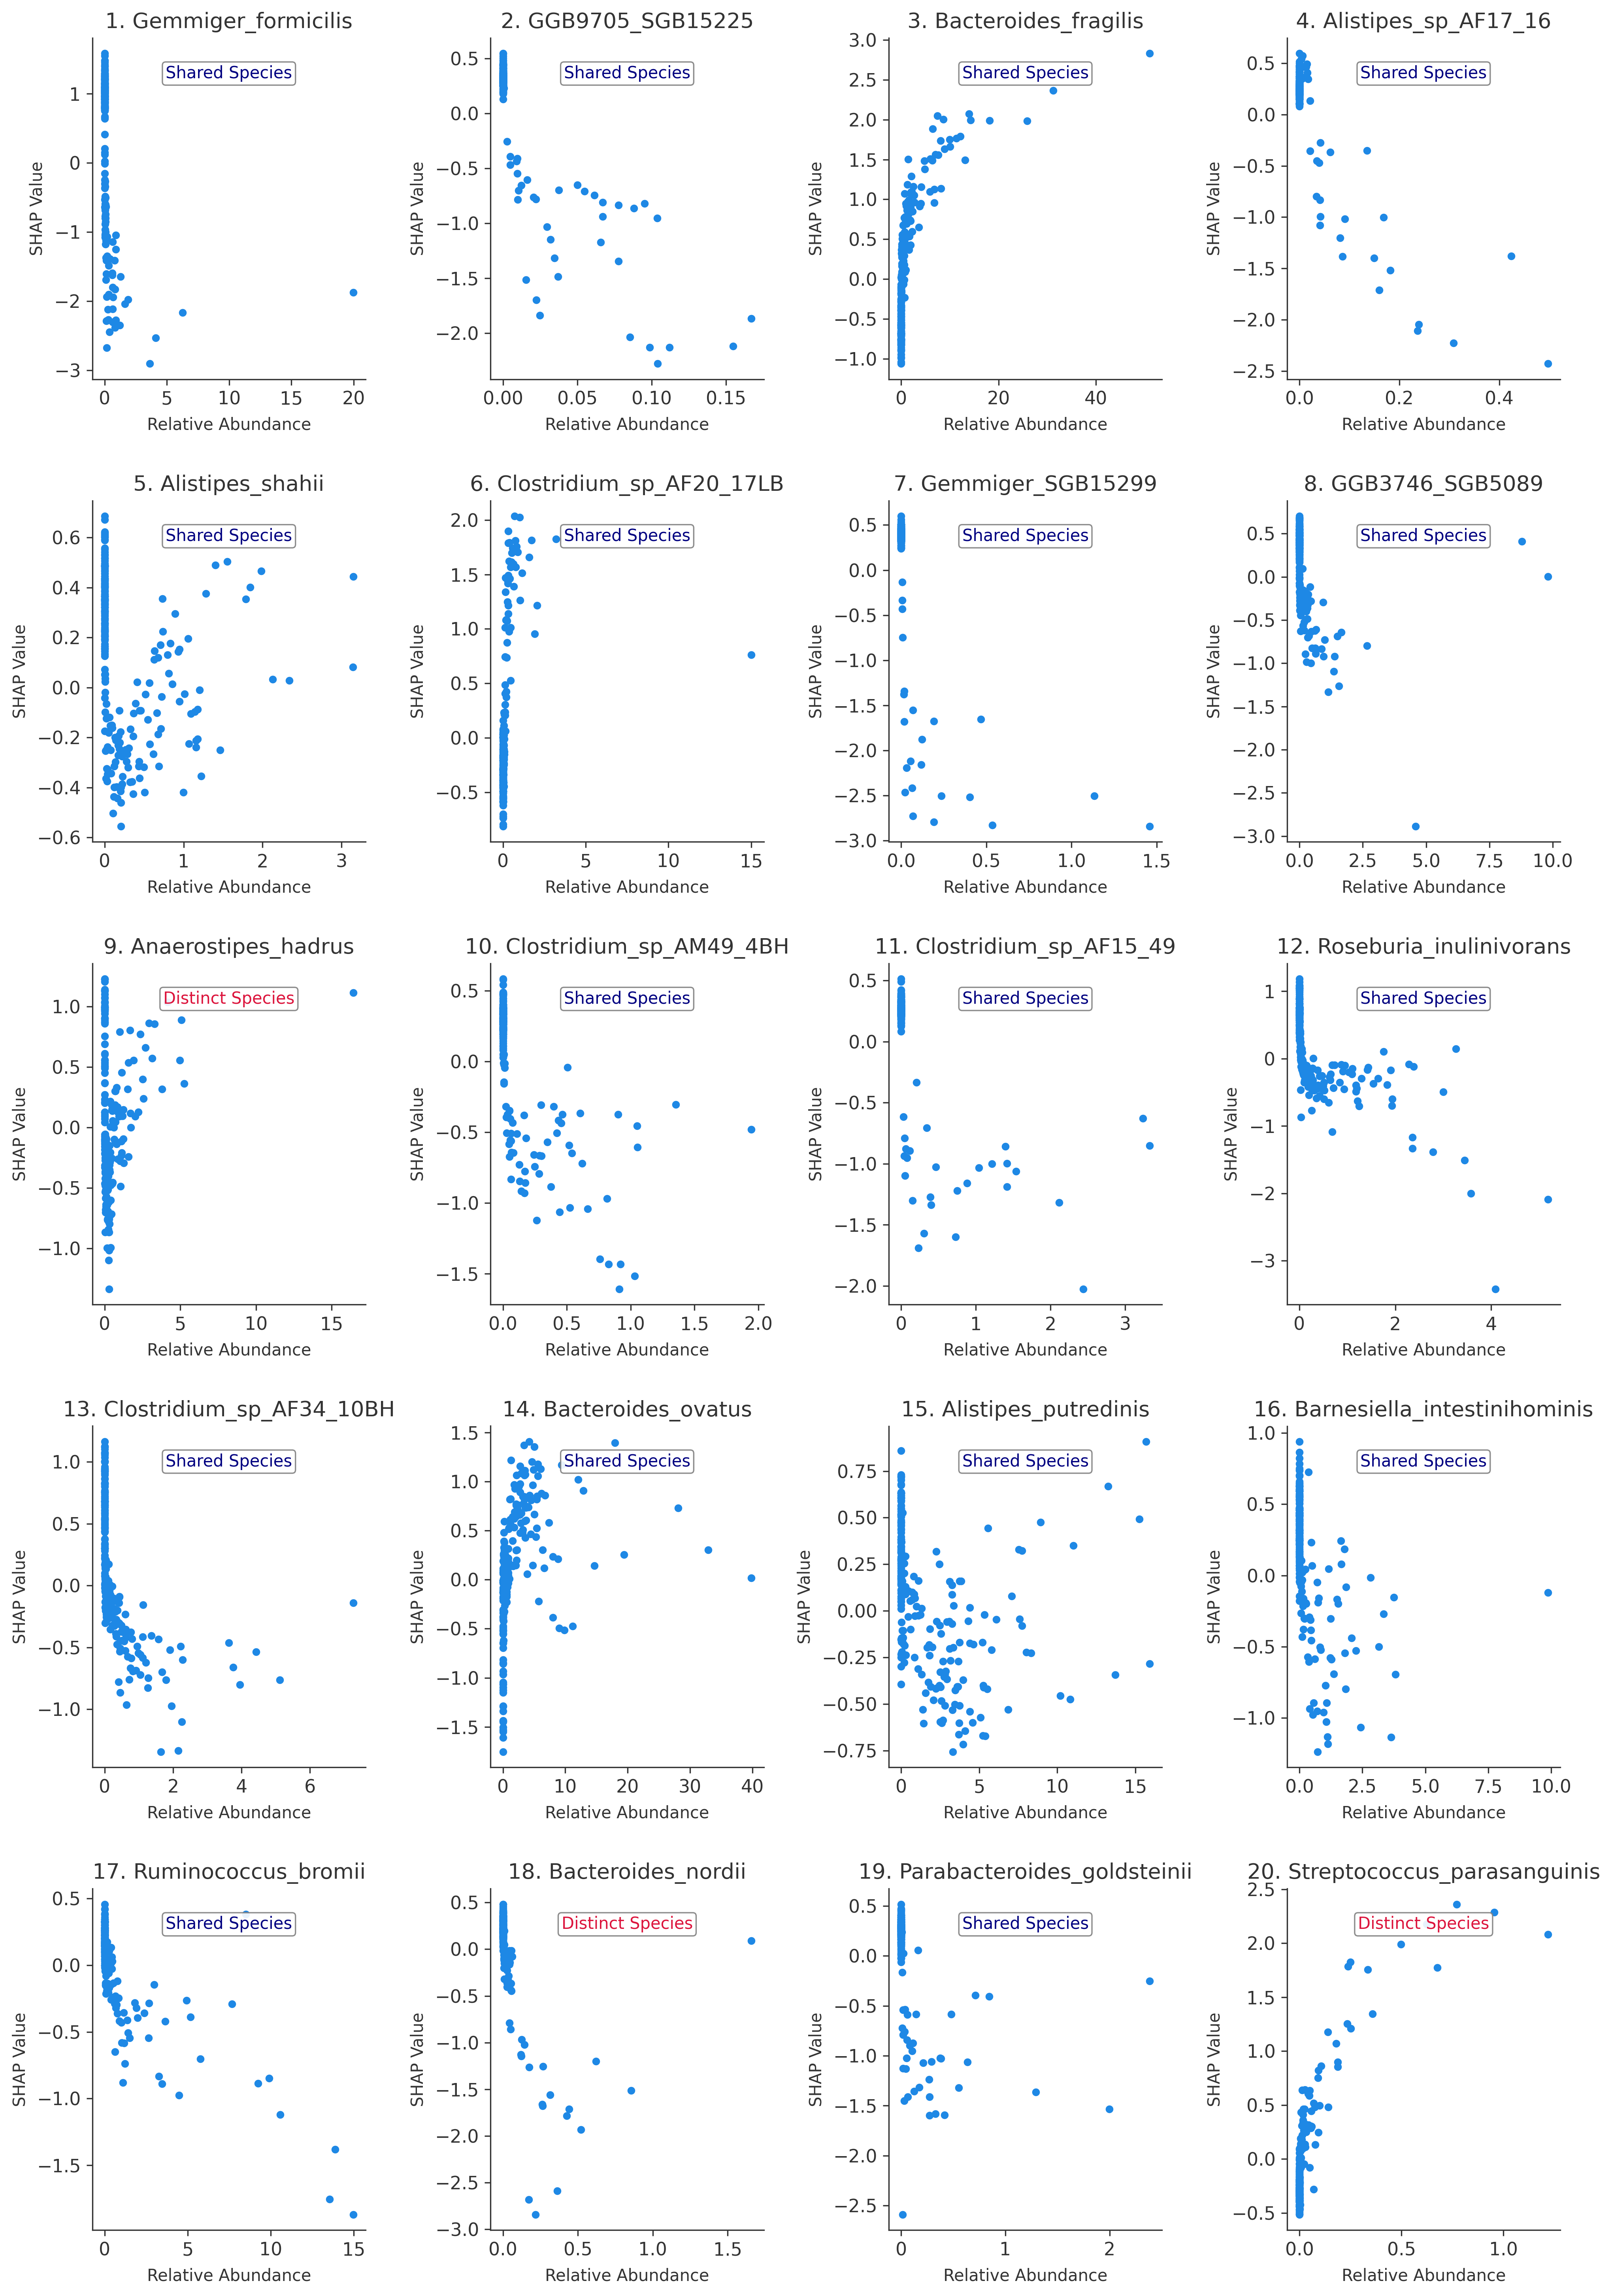

In [ ]:
plt.figure(figsize=(14, 20))

# Use of exclusive pruned function variables
pruned_features = final_features  # Correctly define the feature source
pruned_shap = explainer.shap_values(X_test[pruned_features])

for i, feature in enumerate(pruned_features, 1):
    ax = plt.subplot(5, 4, i)

    # Index of the column where the feature is located (must be from pruned_features)
    feature_idx = pruned_features.index(feature)

    # Ensure dimension alignment through indexing operations
    shap.dependence_plot(
        feature_idx,  # Parameters changed from name to index position
        pruned_shap,
        X_test[pruned_features].values,  # Using NumPy arrays to ensure compatibility
        interaction_index=None,
        ax=ax,
        title=f"{i}. {feature[:30]}".rstrip('_'),
        cmap=cmap,
        dot_size=22,
        show=False
    )

    # Dynamic adjustment of axes
    ax.set_xlabel("Relative Abundance", fontsize=10)
    ax.set_ylabel("SHAP Value", fontsize=10)

    # Update tag position (centered below title)
    label_y_position = 0.92  # Located below the title (standardized coordinates)
    bbox_props = dict(boxstyle="round,pad=0.2", fc="white", ec="grey", lw=0.8, alpha=0.9)

    if feature in distinct_species_list:
        ax.text(0.5, label_y_position, 'Distinct Species',
               color='crimson', fontsize=10,
               ha='center', va='top',  # Horizontally centered, vertically top-aligned
               transform=ax.transAxes,  # Using a relative coordinate system
               bbox=bbox_props)
    elif feature in shared_species_list:
        ax.text(0.5, label_y_position, 'Shared Species',
               color='navy', fontsize=10,
               ha='center', va='top',
               transform=ax.transAxes,
               bbox=bbox_props)

# Enhanced layout control
plt.tight_layout(pad=3.0, h_pad=2.5, w_pad=2.0)
plt.savefig("/content/drive/MyDrive/code/IBD/2stage/stage1/SHAP_dependence_pruned_model.png", dpi=300, bbox_inches='tight')
plt.show()